**NER**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
# raot_cta_ner = pd.read_csv('ner_data.csv')
raot_cta_ner = pd.read_csv('trailing.csv')
print(raot_cta_ner['PROPERTY_ID'].nunique())
raot_cta_ner.head()
print(raot_cta_ner.shape)

18554
(1625275, 14)


In [3]:
raot_cta_ner['WEEK_START'] = pd.to_datetime(raot_cta_ner['SURVEY_DATE']).dt.date
raot_cta_ner = raot_cta_ner.sort_values(by='WEEK_START')

# select rows where date is between given start/end date (inclusive)
start_date = pd.to_datetime('1/1/2015')
end_date = pd.to_datetime('8/14/2022')

raot_cta_ner = raot_cta_ner.loc[
    (raot_cta_ner['WEEK_START'] >= start_date) & (raot_cta_ner['WEEK_START'] <= end_date)]

In [4]:
def start_week_date(survey_date):
    start_date = survey_date - timedelta(days=survey_date.weekday())
    
    return start_date

raot_cta_ner['WEEK_START'] = raot_cta_ner.apply(lambda x: start_week_date(x['WEEK_START']), axis=1)
raot_cta_ner.tail()

,WEEK_START,PROPERTY_ID,SURVEY_ID,SURVEY_DATE,STATE,STATE_ID,MSA,MSA_ID,SUBMARKET,SUBMARKET_ID,NER,NER_T4,UNITS,UNITS_T4
1156653,2022-08-08,5e8775f9c852ab001dab89b8,62f97a31c433445bd07de258,2022-08-14,Florida,de4bebc6-220a-8701-3dae-c1612fdd70d6,"Palm Bay, FL",f7aedb43-1a93-6d47-31f5-17b004181050,Other,122ac9c4419e6fb6e8c07f3d5dacfd4a,1905.208108,1898.782432,370.0,370.0
1588179,2022-08-08,618bf7c6c89eac00030efc9c,62f93618c9a0902533dcb24f,2022-08-14,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"San Jose, CA",6e9d1acc-9171-a389-2994-fd1657f71fbe,Central San Jose,9755a8c3d7b37fa9a77a0fdef2893c68,2202.915492,2202.915492,71.0,71.0
1198006,2022-08-08,5e8e030e4187c8001d0f5bbe,62f8d6e7c9a0902533dc97ee,2022-08-14,Utah,8bbb2ecf-2363-8300-2ad1-d901e3de9060,"Salt Lake City, UT",2f5f2086-1988-a66b-369b-379604184eb8,West Jordan,8bca891c9e2160aa246a28b3ba357937,1430.391666,1469.316666,120.0,120.0
1011928,2022-08-08,5e25d6e373d847001d1fde6c,62f84a7ffeebc840e4b8338c,2022-08-14,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"San Diego, CA",dfad4dd3-9313-6c18-50c1-0de9821b0d67,Oceanside,908eeeeb66aaa72d310634ff4ce351ce,2821.609756,2821.609756,410.0,410.0
243468,2022-08-08,5c49fde0688f600015565081,62f98a82ba4796364444c6bd,2022-08-14,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"San Jose, CA",6e9d1acc-9171-a389-2994-fd1657f71fbe,Mountain View/Los Altos,5783823e2e5e87cd0df2cd96134d7d85,4607.166666,4607.166666,12.0,12.0


In [5]:
raot_cta_ner = raot_cta_ner[['WEEK_START', 'PROPERTY_ID', 'STATE', 'MSA', 'SUBMARKET', 'NER_T4']]

## XGBOOST

In [6]:
subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['STATE']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER_T4')

In [7]:
print(list(subsets.keys())[0])
list(subsets.values())[0]

Alabama


,NER_T4
WEEK_START,
2017-10-02,601.455573
2017-10-09,746.401592
2017-10-16,741.222065
2017-10-23,747.973735
2017-10-30,910.413878
...,...
2022-07-11,1299.891748
2022-07-18,1303.969294
2022-07-25,1294.699482


In [8]:
def datetime_index(df, date_col):
    datetime_series = pd.to_datetime(df[date_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df2 = df.set_index(datetime_index)
    df2.drop('date',axis=1,inplace=True)
    return df2

In [9]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [10]:
def datetime_index(df, date_col):
    datetime_series = pd.to_datetime(df[date_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df2 = df.set_index(datetime_index)
    df2.drop('date',axis=1,inplace=True)
    return df2

In [11]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [12]:
def evaluation(test_data, predictions):
    mape = mean_absolute_percentage_error(predictions, test_data)
    return mape

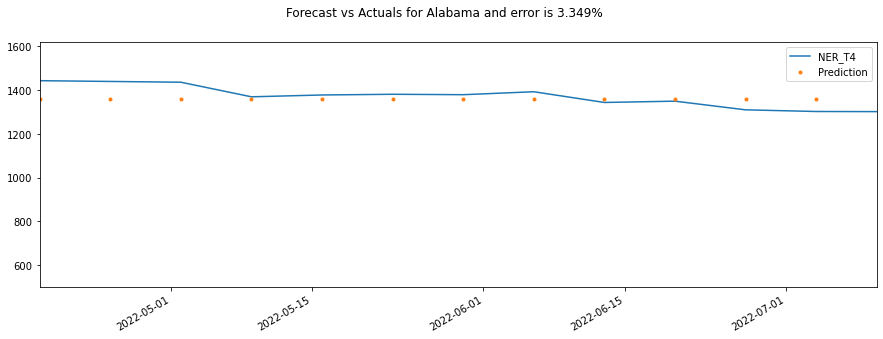

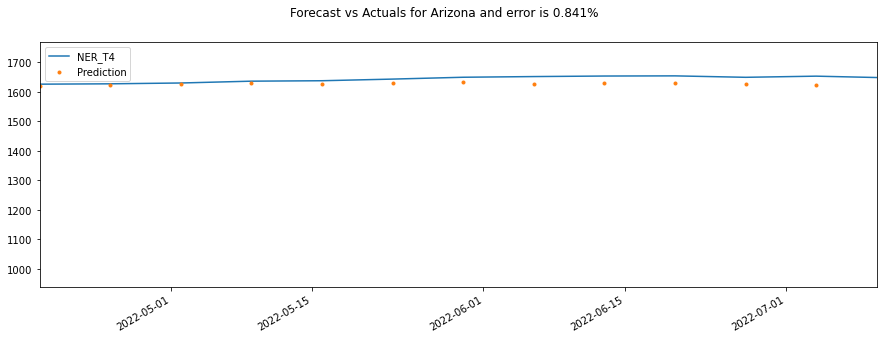

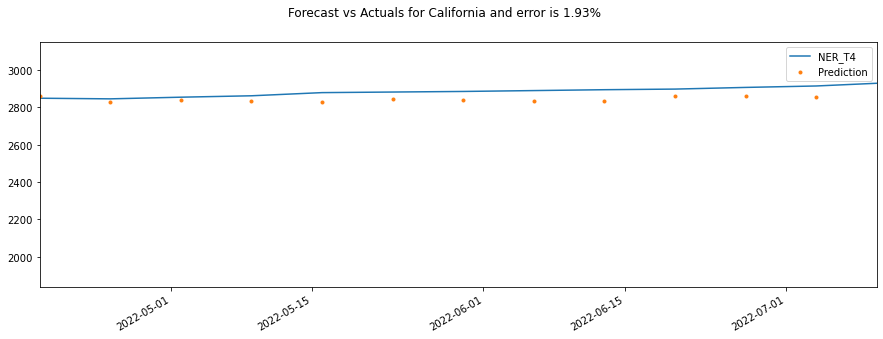

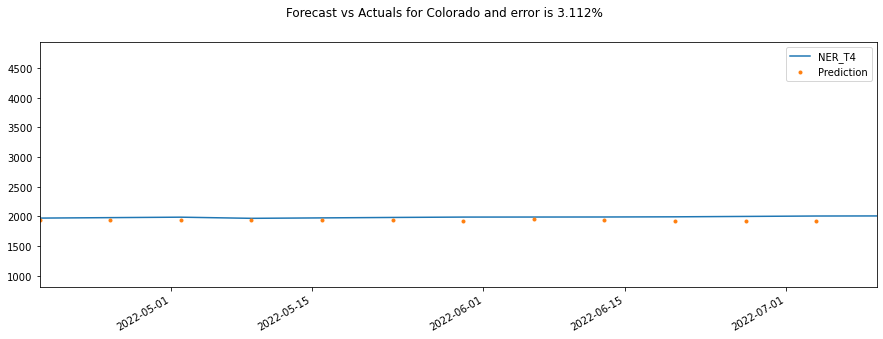

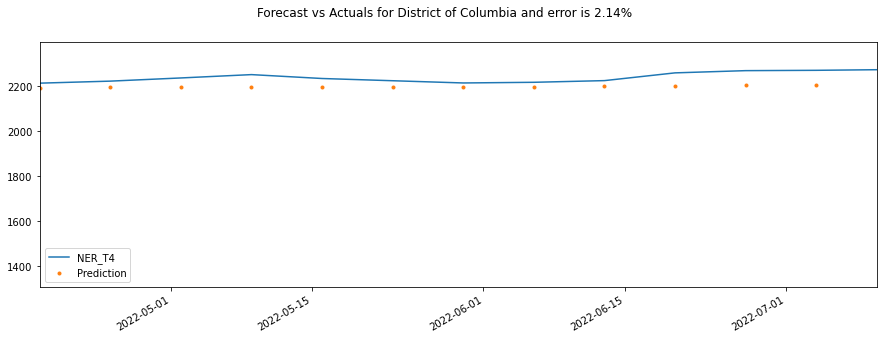

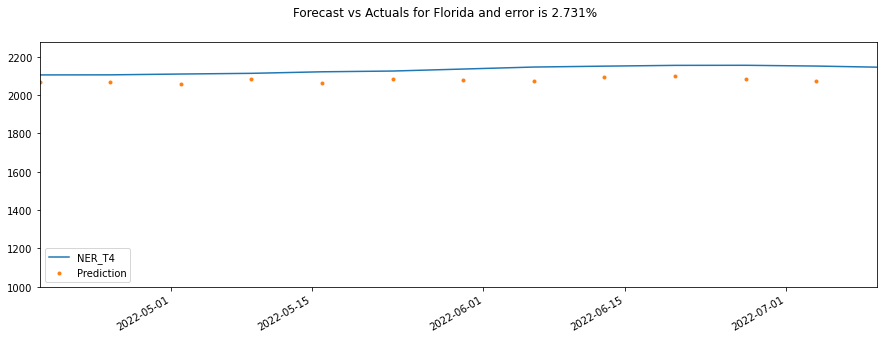

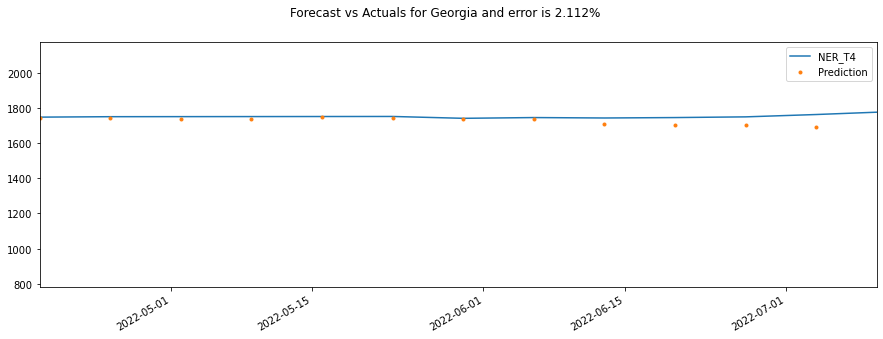

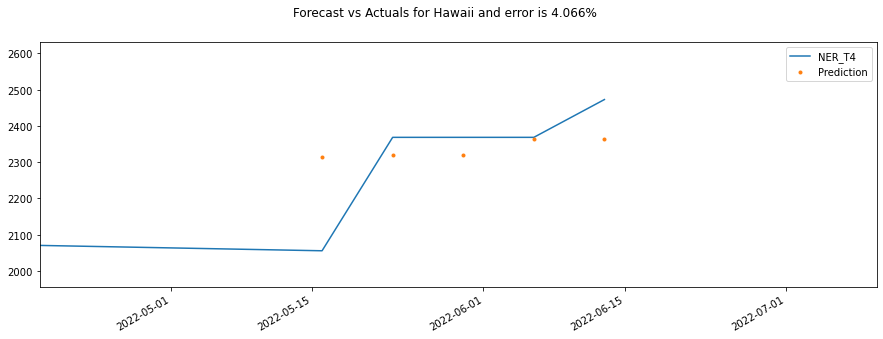

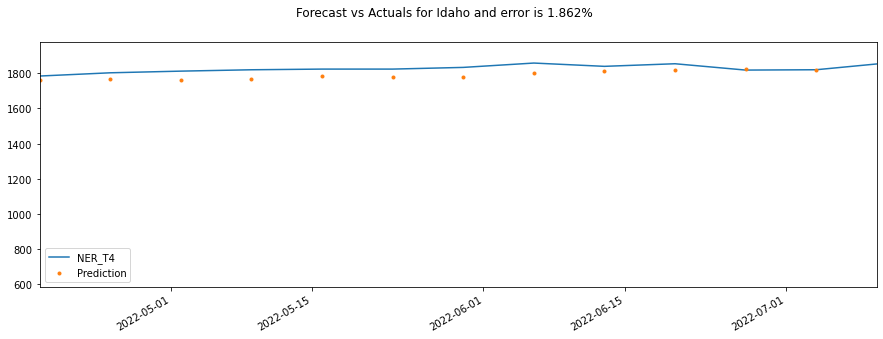

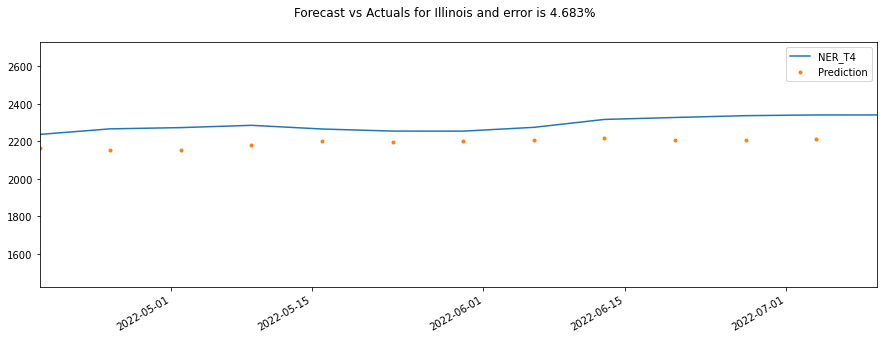

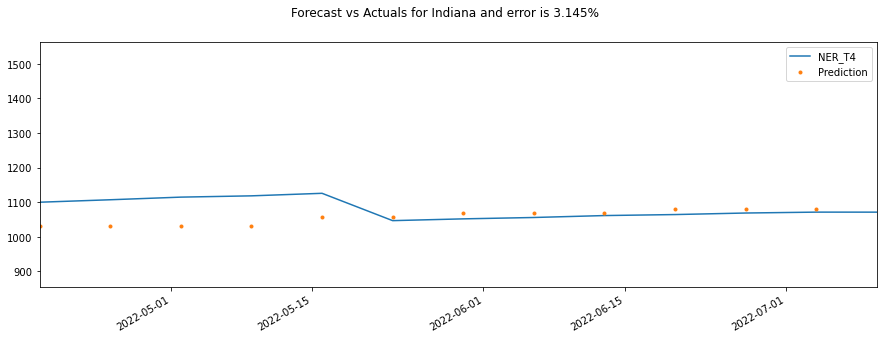

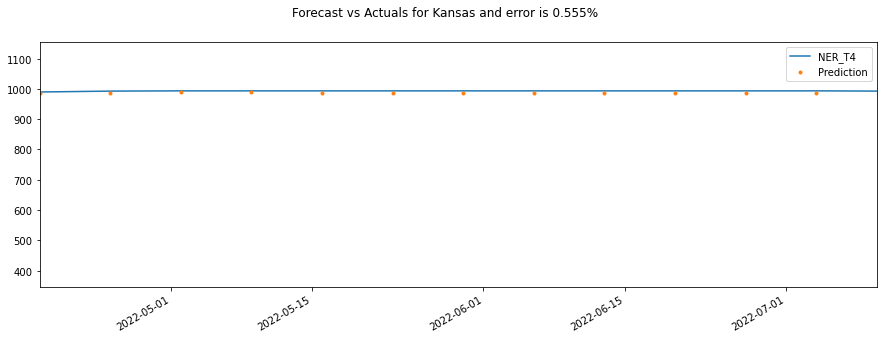

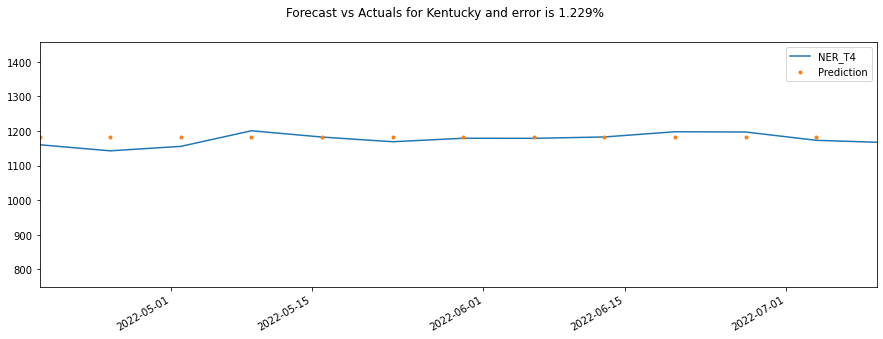

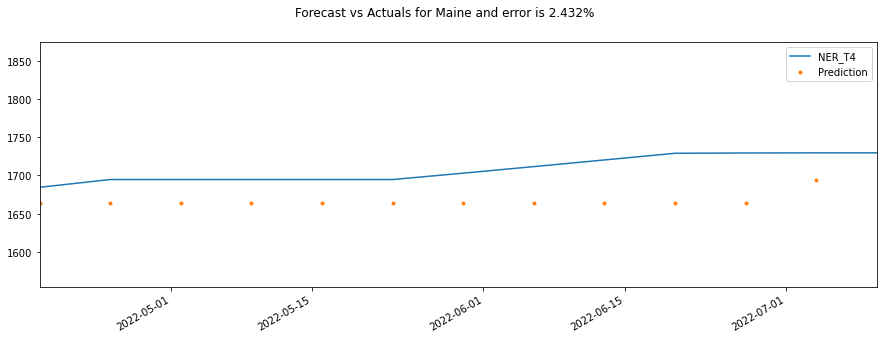

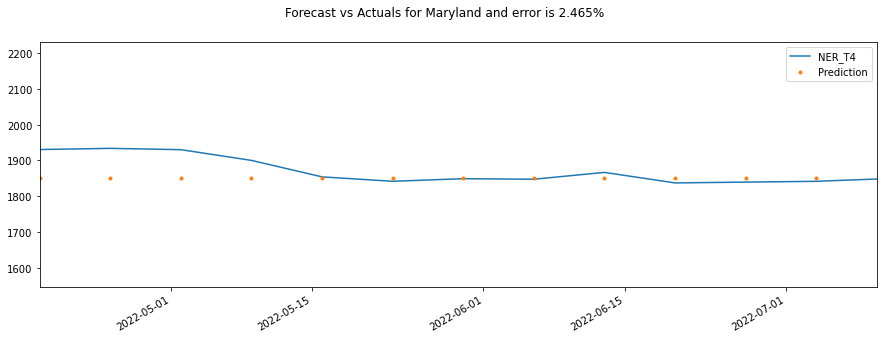

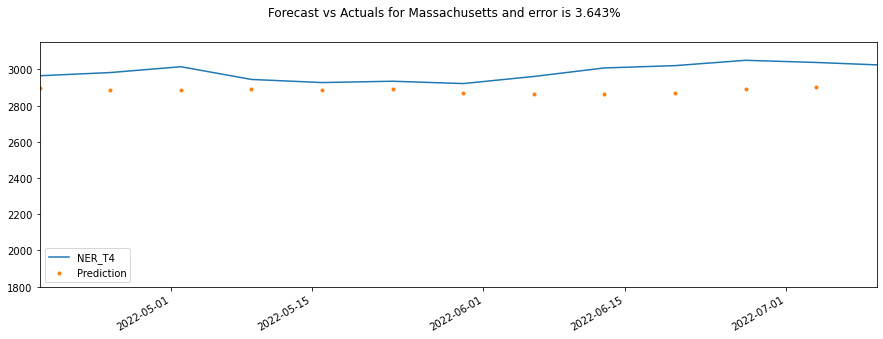

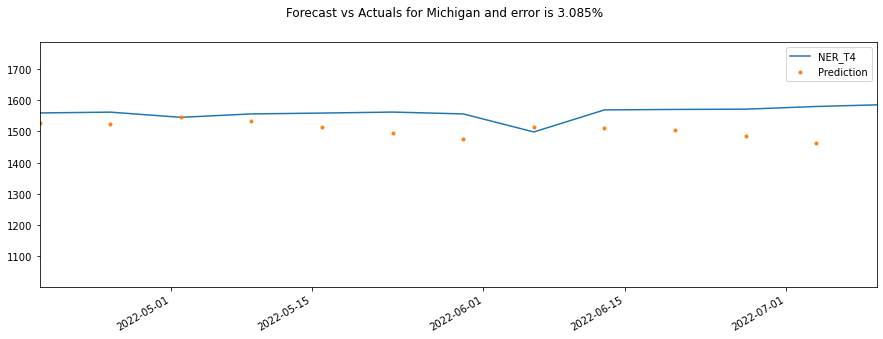

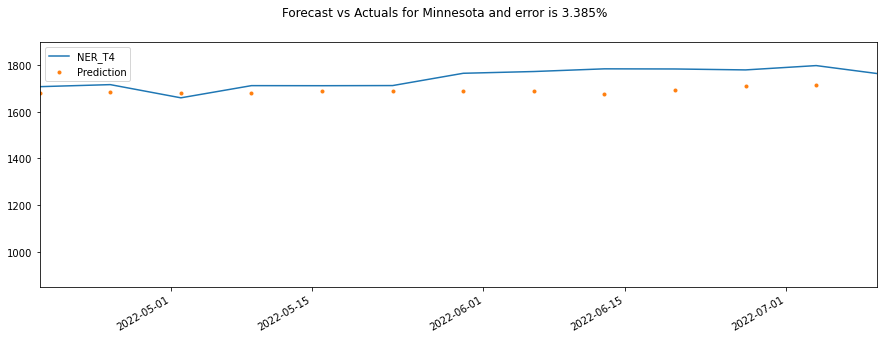

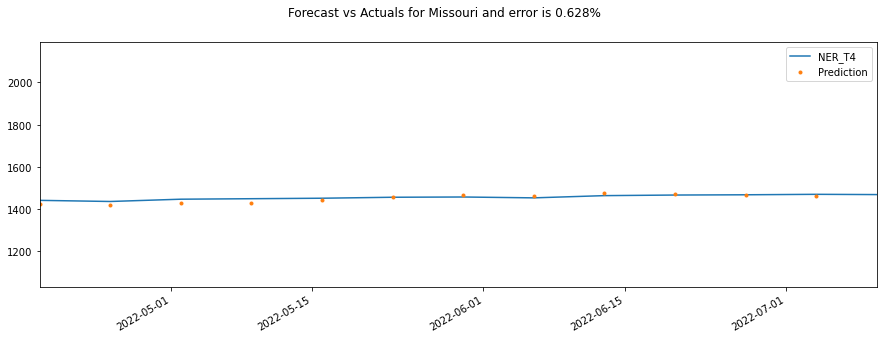

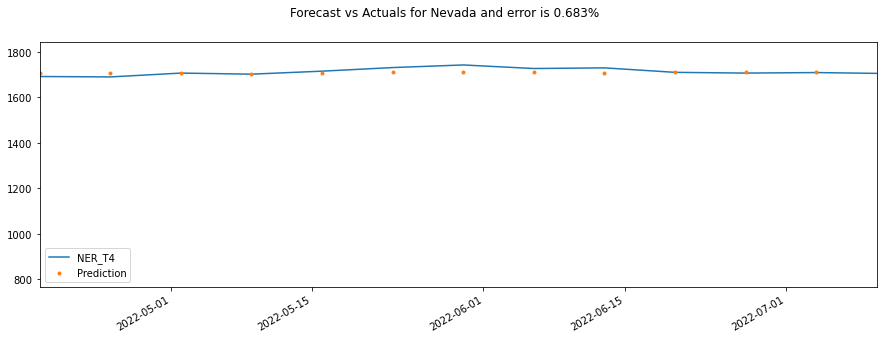

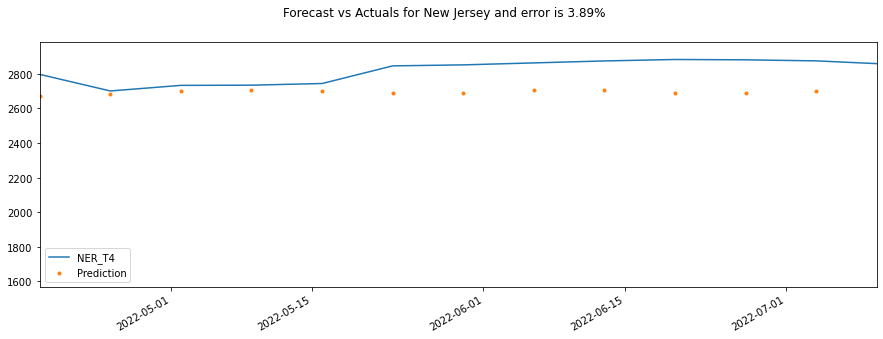

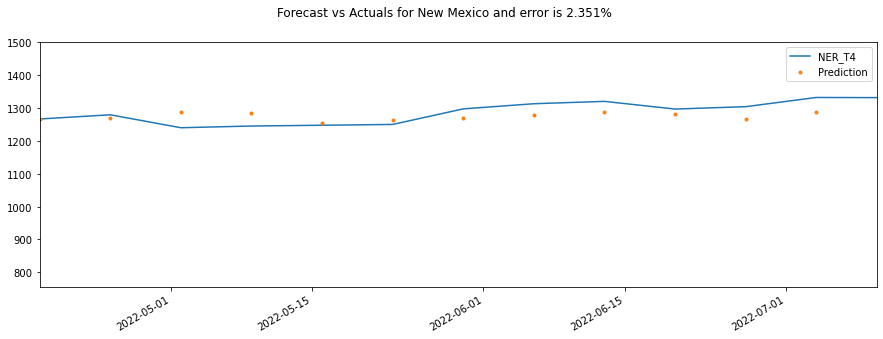

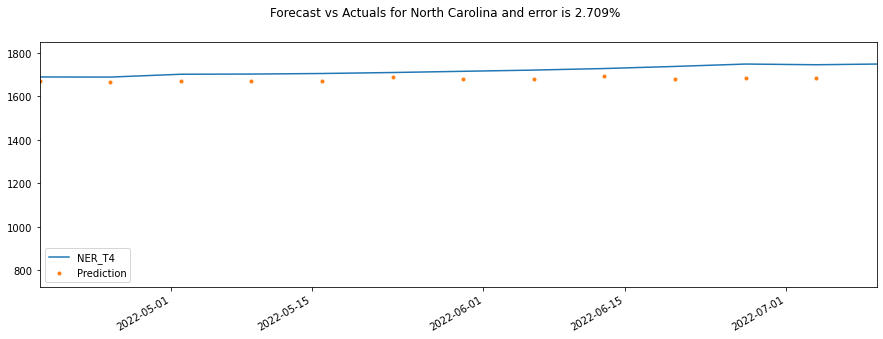

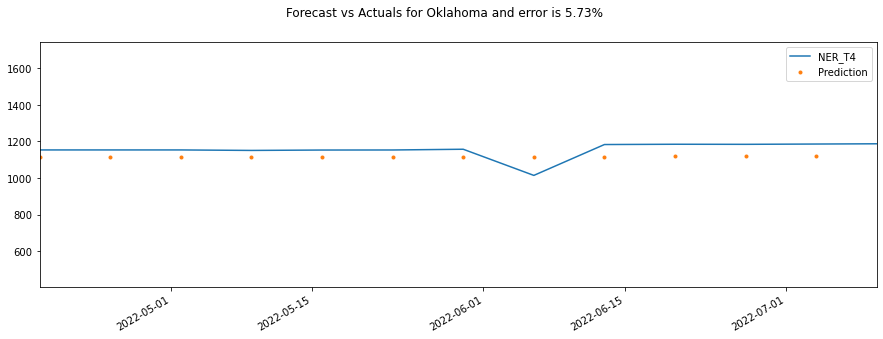

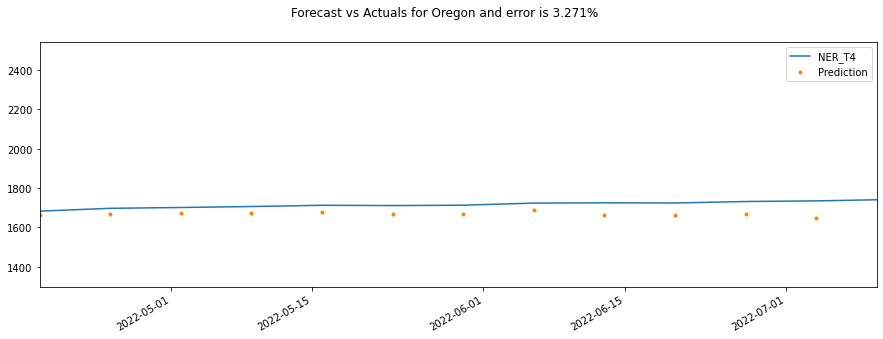

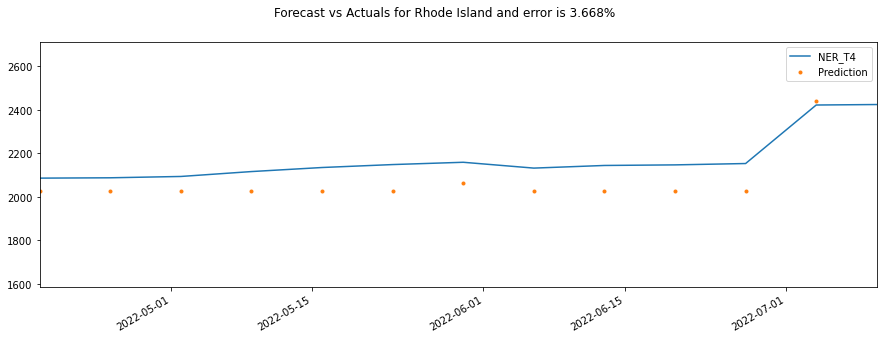

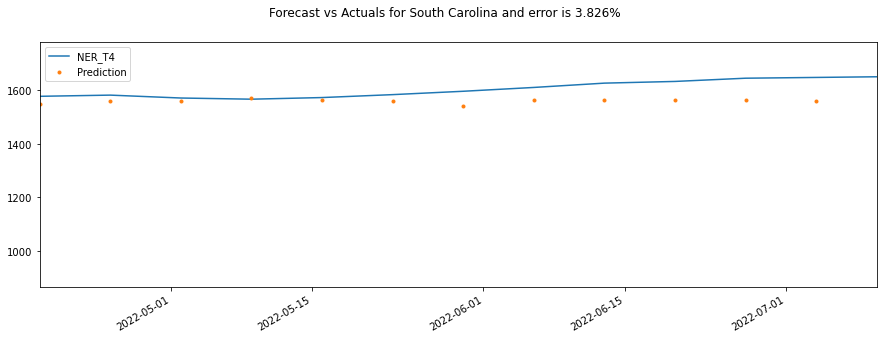

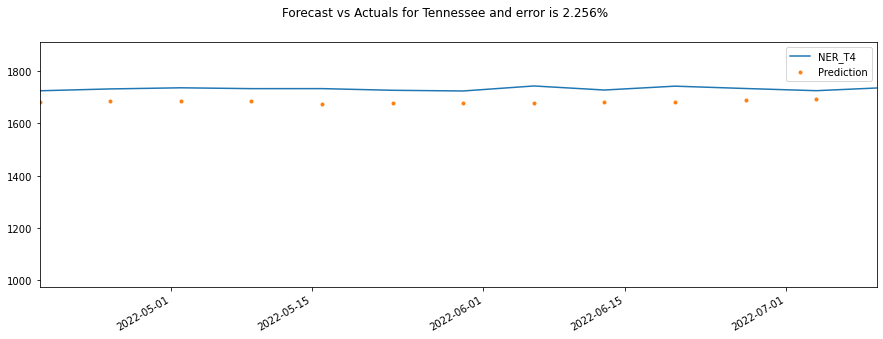

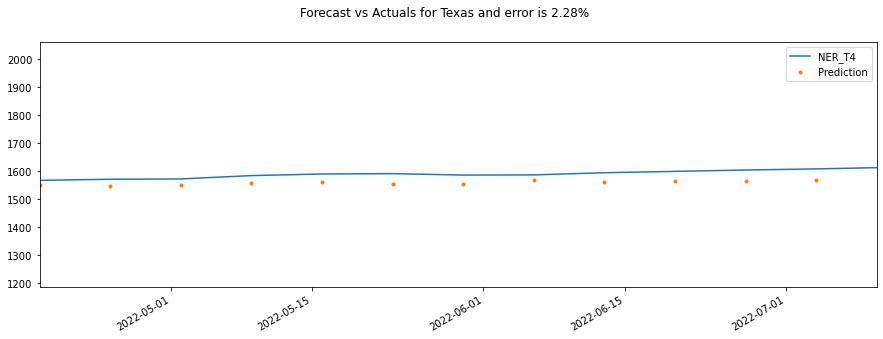

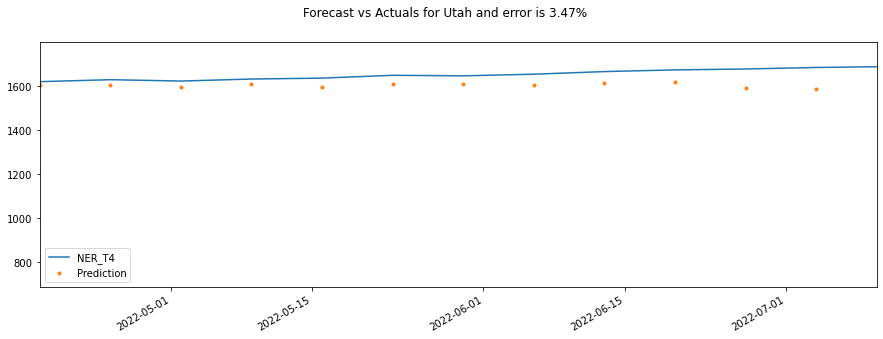

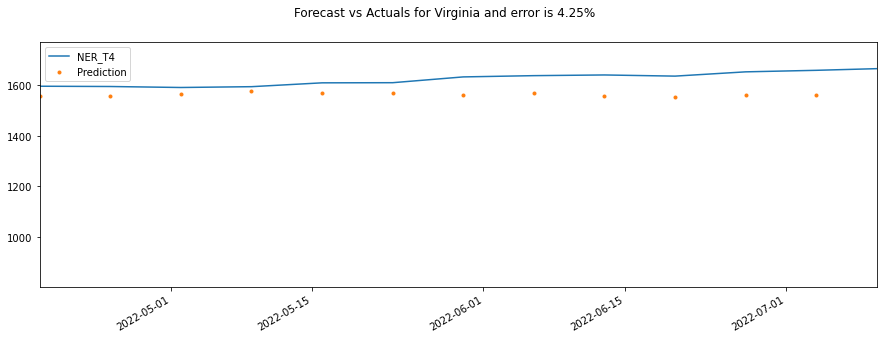

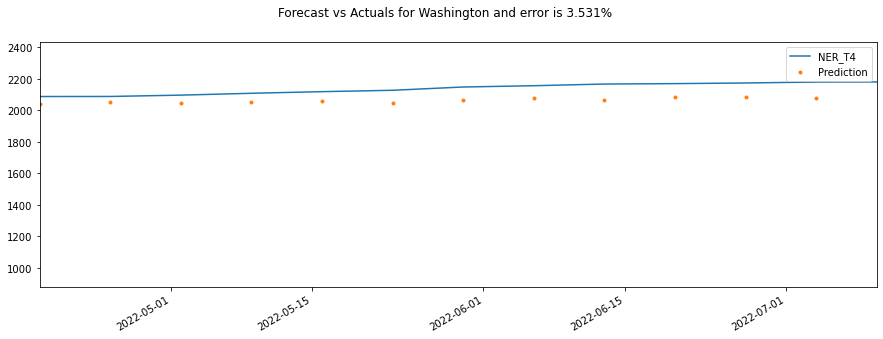

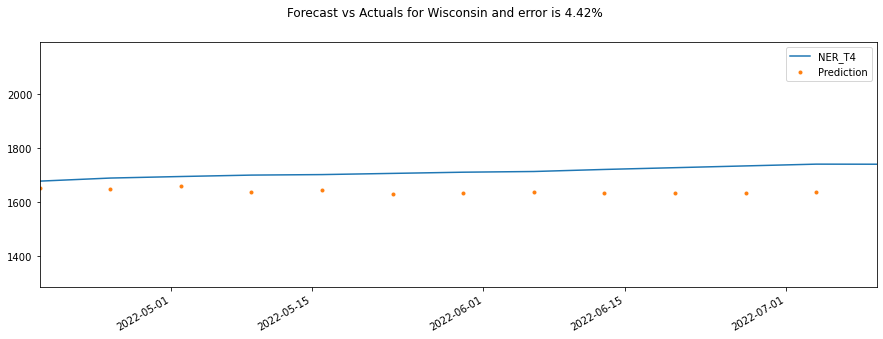

In [13]:
for unique_val, subset in subsets.items():
    split_date = date(2022, 4, 4)
    subset['date'] = subset.index
    df_train = subset.loc[subset.index <= split_date].copy()
    df_test = subset.loc[subset.index > split_date].copy()
    df_train = datetime_index(df_train, 'date')
    df_test = datetime_index(df_test, 'date')
    X_train, y_train = create_features(df_train, label='NER_T4')
    X_test, y_test = create_features(df_test, label='NER_T4')
    reg = xgb.XGBRegressor(n_estimators=200)
    
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)     
    
    df_test['Prediction'] = reg.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    
    
    mape = evaluation(df_test['NER_T4'], df_test['Prediction'])
    
    if mape < 0.06:
        f, ax = plt.subplots(1)
        f.set_figheight(5)
        f.set_figwidth(15)
        _ = df_all[['NER_T4','Prediction']].plot(ax=ax, style=['-','.'])


        ax.set_xbound(lower='04-18-2022', upper='07-10-2022')
        ax.set_ylim(min(subset['NER_T4'])-100,max(subset['NER_T4'])+100)

        mape = evaluation(df_test['NER_T4'], df_test['Prediction'])
        plot = plt.suptitle(f'Forecast vs Actuals for {unique_val} and error is {round(mape*100,3)}%')

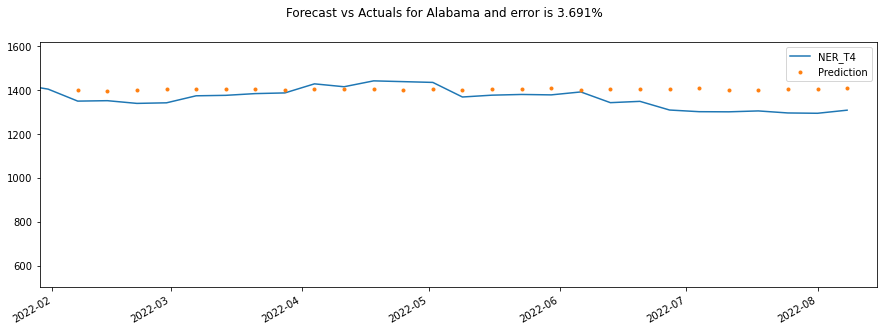

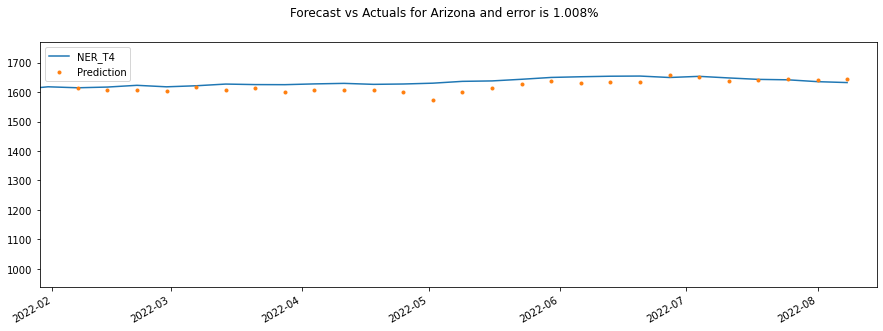

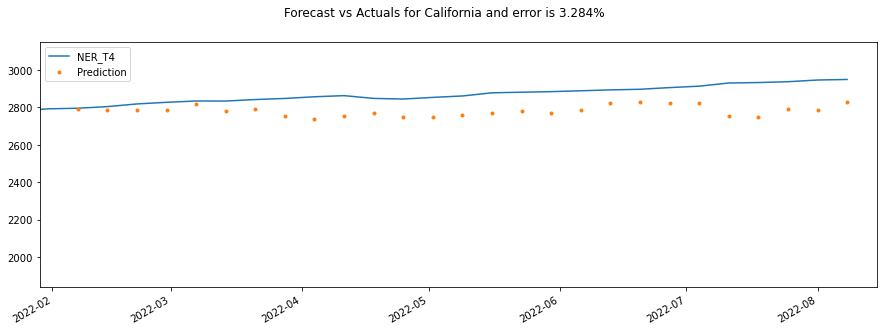

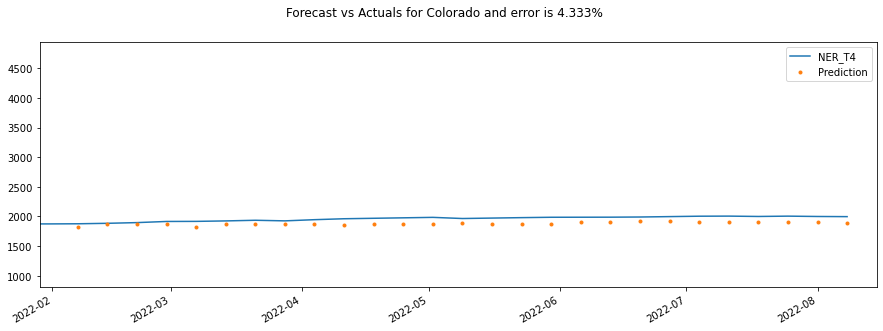

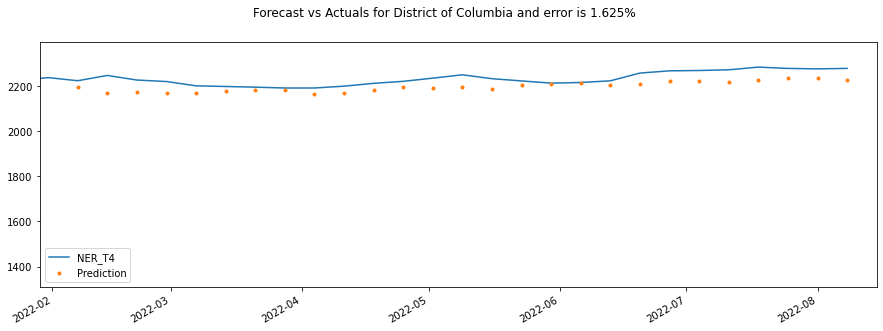

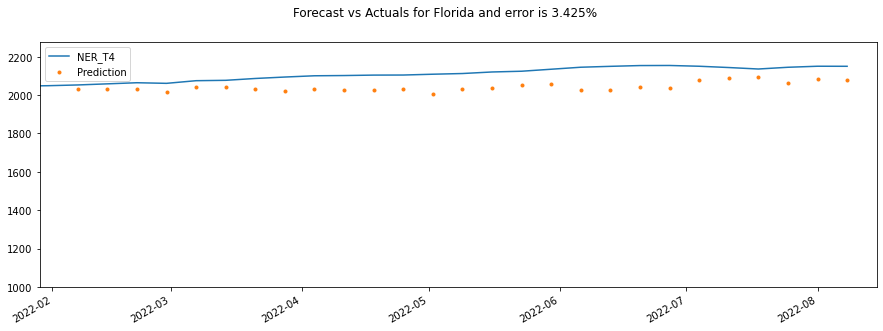

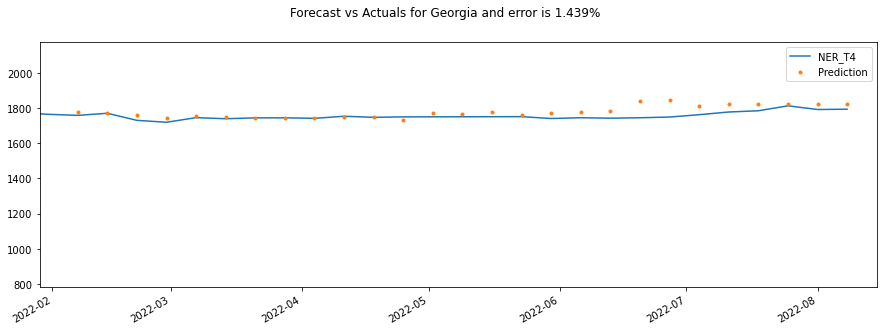

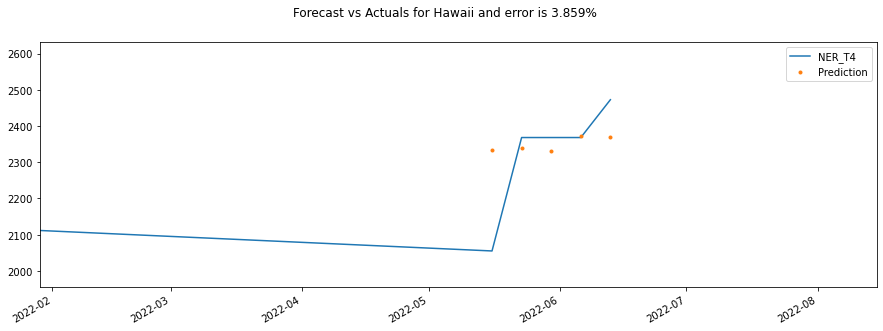

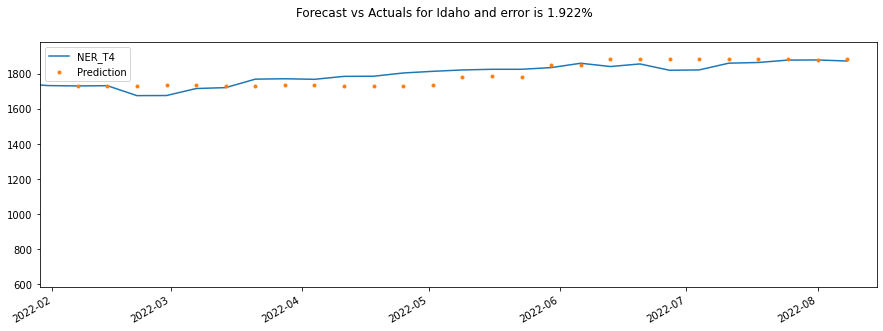

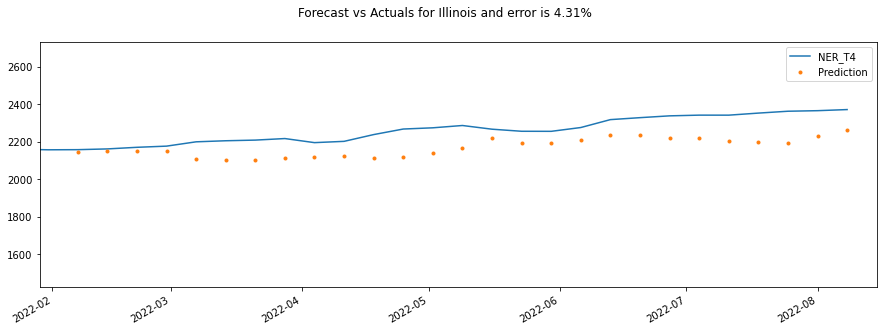

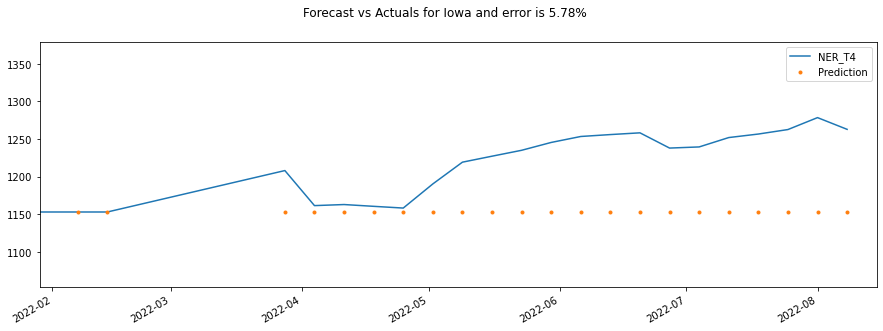

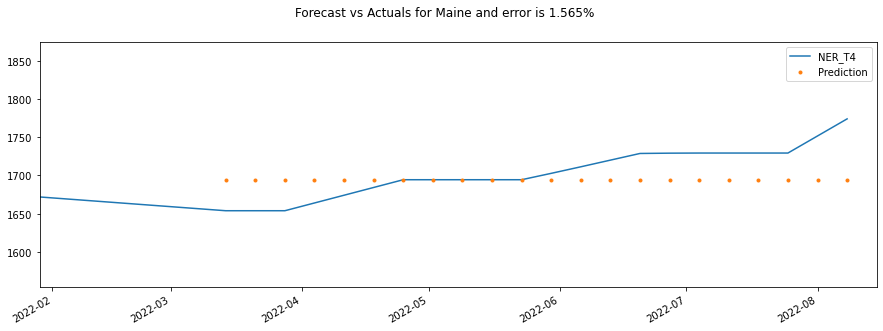

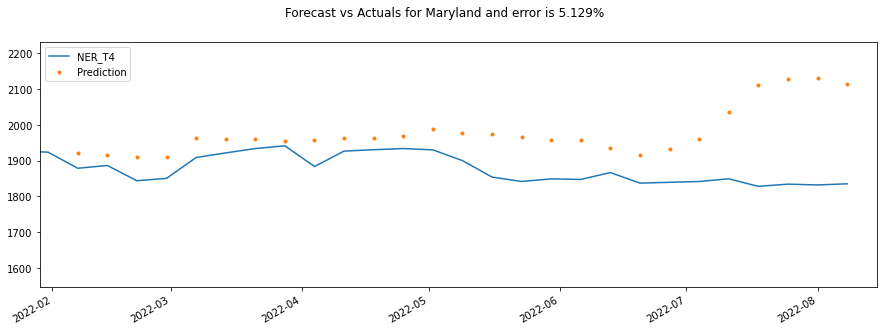

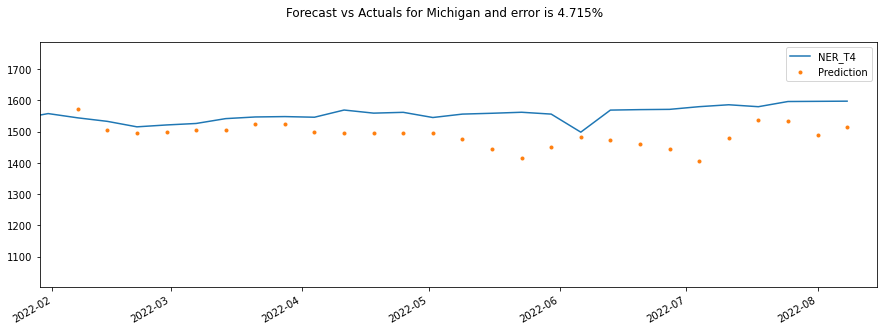

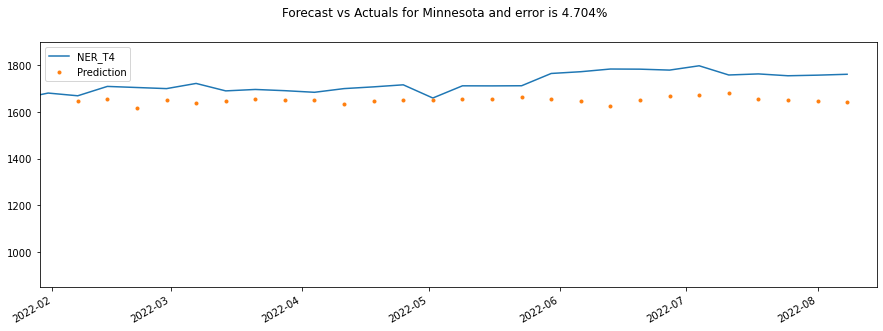

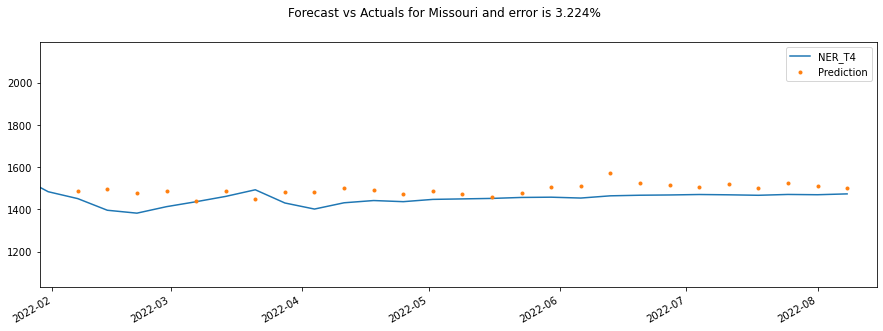

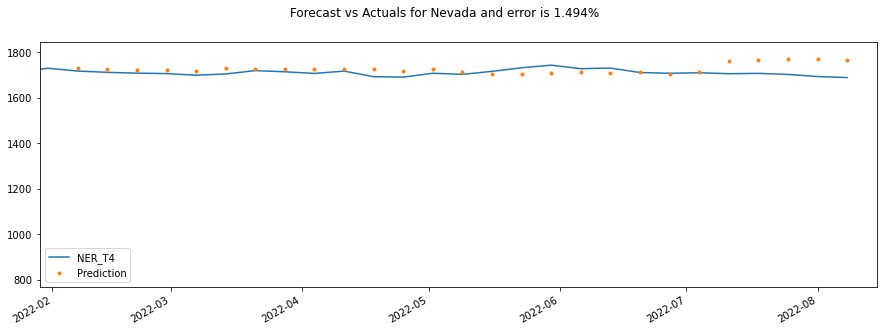

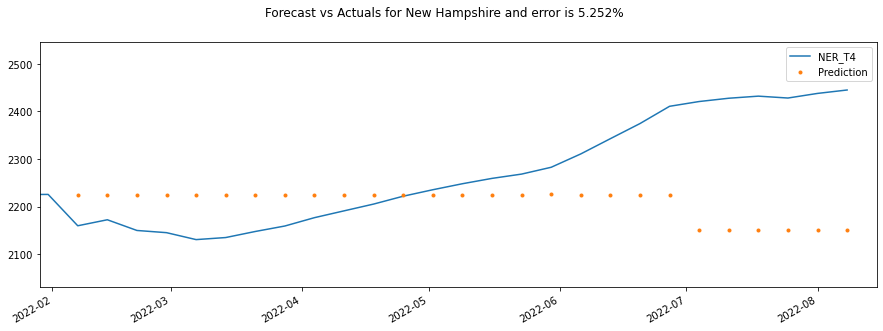

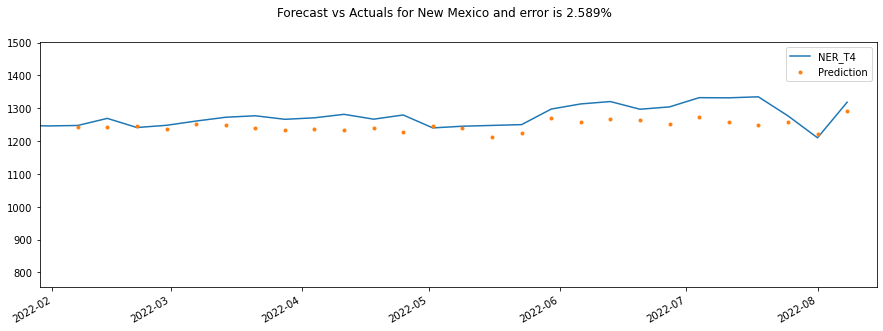

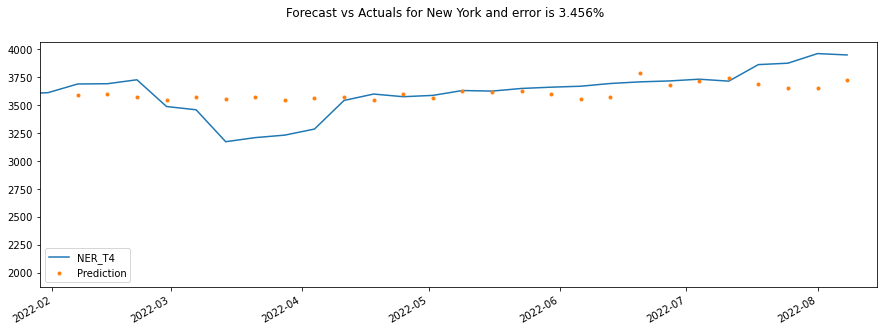

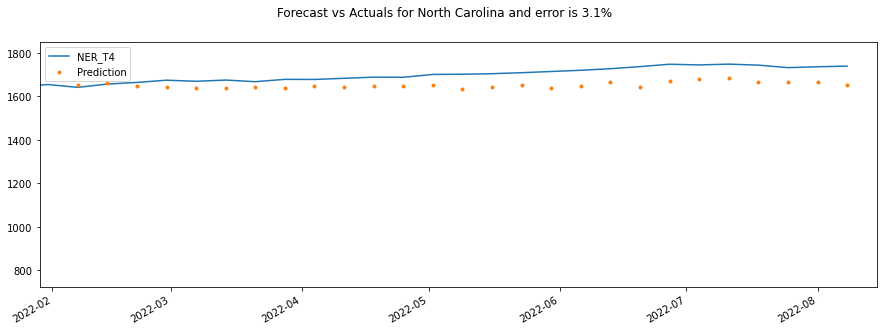

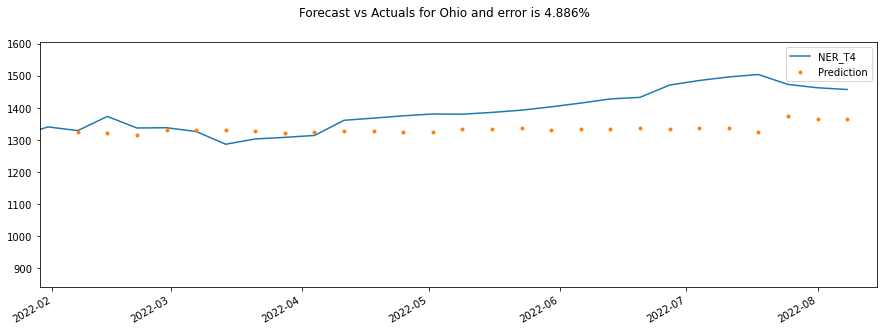

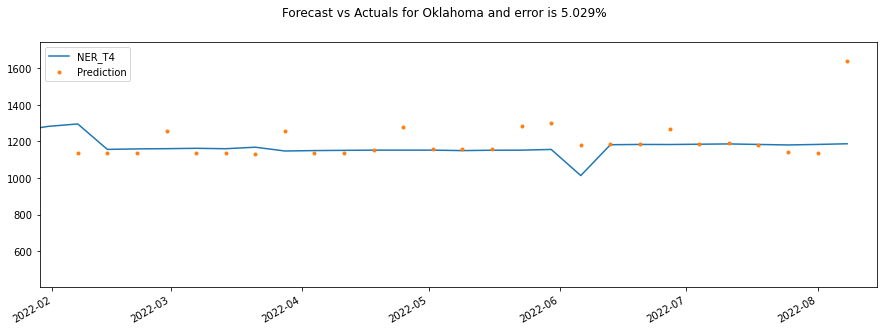

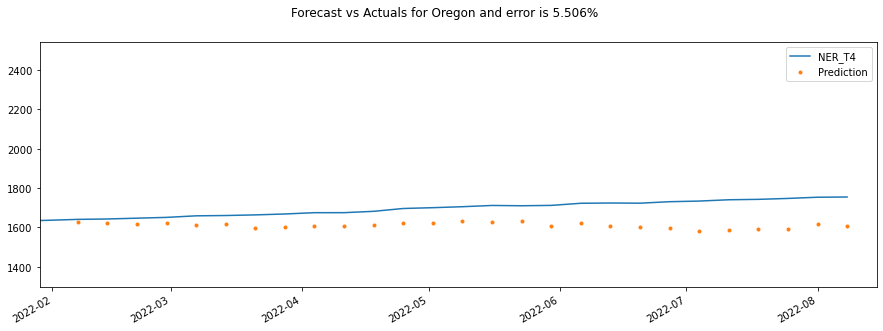

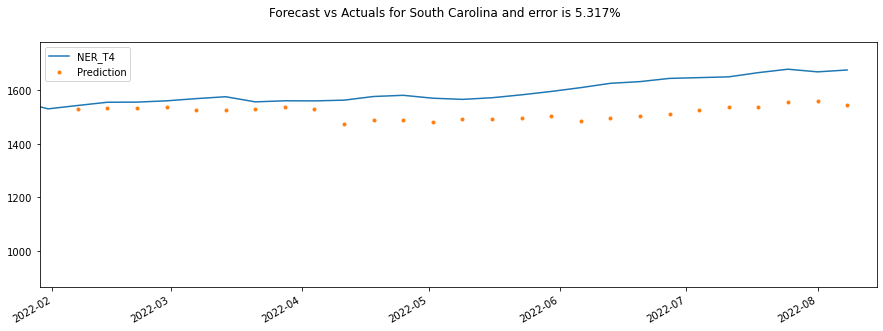

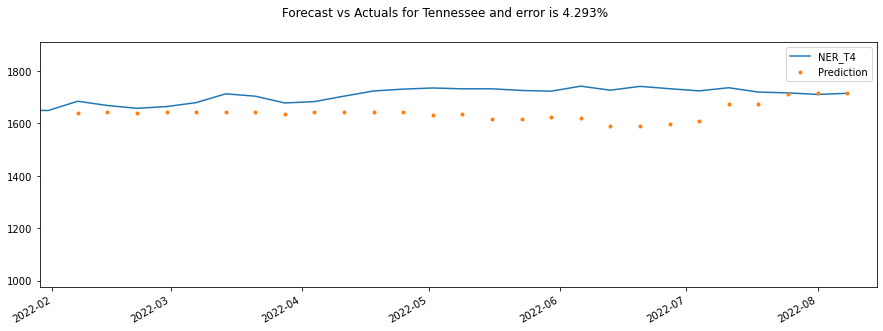

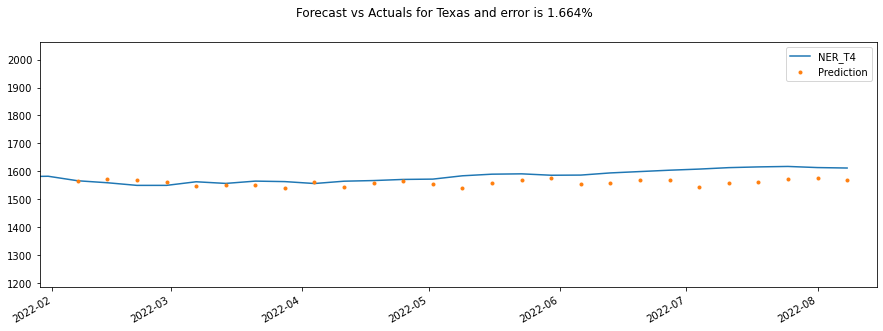

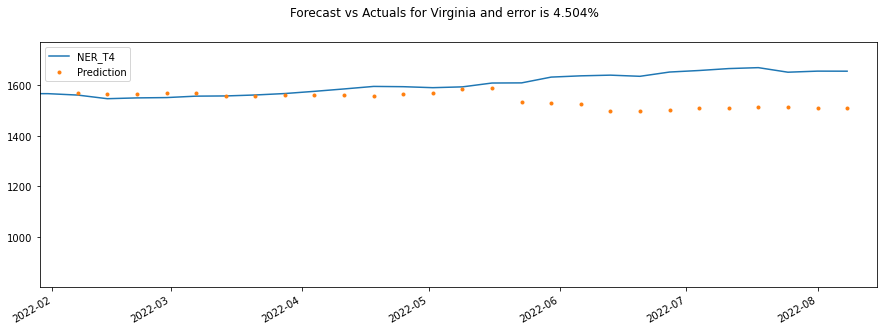

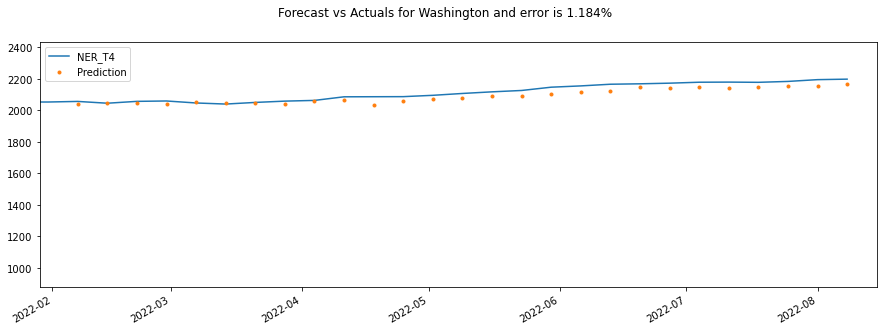

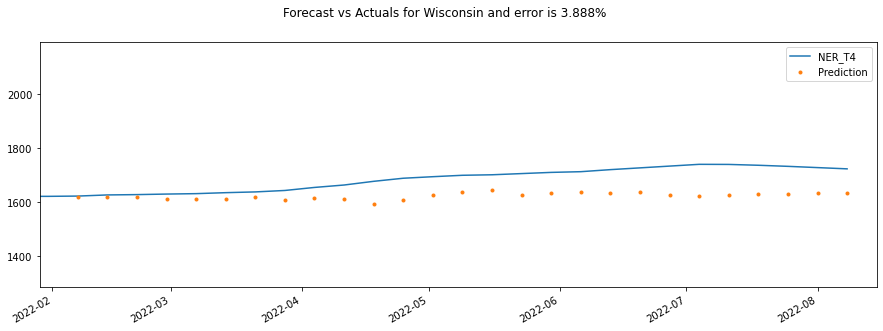

In [14]:
for unique_val, subset in subsets.items():
    split_date = date(2022, 2, 1)
    subset['date'] = subset.index
    df_train = subset.loc[subset.index <= split_date].copy()
    df_test = subset.loc[subset.index > split_date].copy()
    df_train = datetime_index(df_train, 'date')
    df_test = datetime_index(df_test, 'date')
    X_train, y_train = create_features(df_train, label='NER_T4')
    
    X_test, y_test = create_features(df_test, label='NER_T4')
    reg = xgb.XGBRegressor(n_estimators=200)
    
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        early_stopping_rounds=50,
       verbose=False)     
    
    df_test['Prediction'] = reg.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    
    mape = evaluation(df_test['NER_T4'], df_test['Prediction'])

    if mape < 0.06:
        f, ax = plt.subplots(1)
        f.set_figheight(5)
        f.set_figwidth(15)
        _ = df_all[['NER_T4','Prediction']].plot(ax=ax, style=['-','.'])


        ax.set_xbound(lower='01-29-2022', upper='08-15-2022')
        ax.set_ylim(min(subset['NER_T4'])-100,max(subset['NER_T4'])+100)

        plot = plt.suptitle(f'Forecast vs Actuals for {unique_val} and error is {round(mape*100,3)}%')

In [15]:
prediction_period = pd.DataFrame(pd.date_range('2022-08-08', periods=24, freq='W'))
prediction_period = prediction_period.rename(columns = {0:'date'})
prediction_period

,date
0,2022-08-14
1,2022-08-21
2,2022-08-28
3,2022-09-04
4,2022-09-11
5,2022-09-18
6,2022-09-25
7,2022-10-02
8,2022-10-09
9,2022-10-16


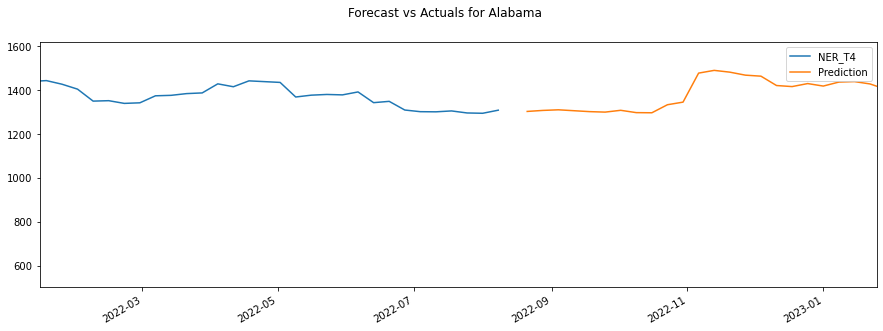

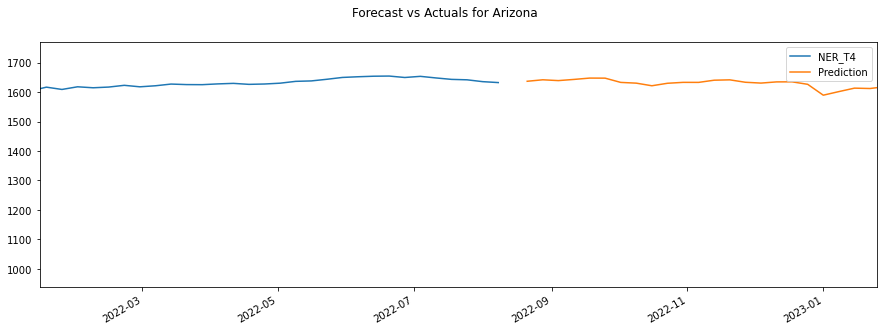

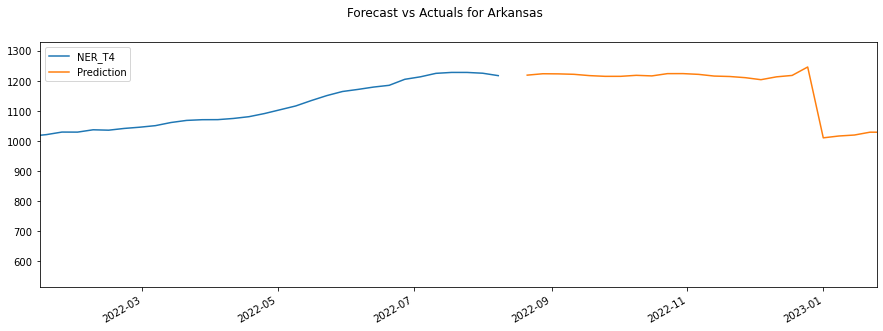

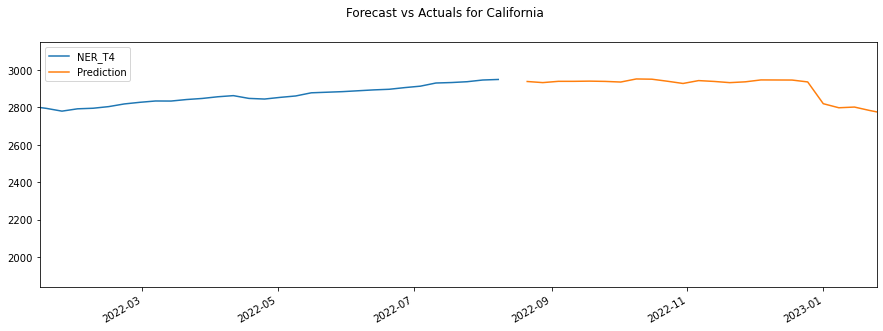

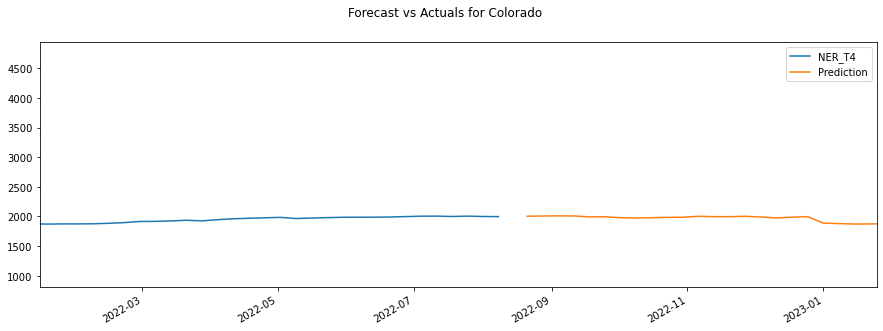

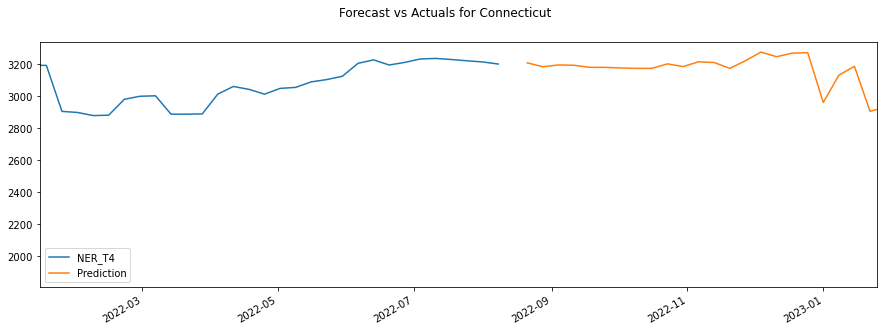

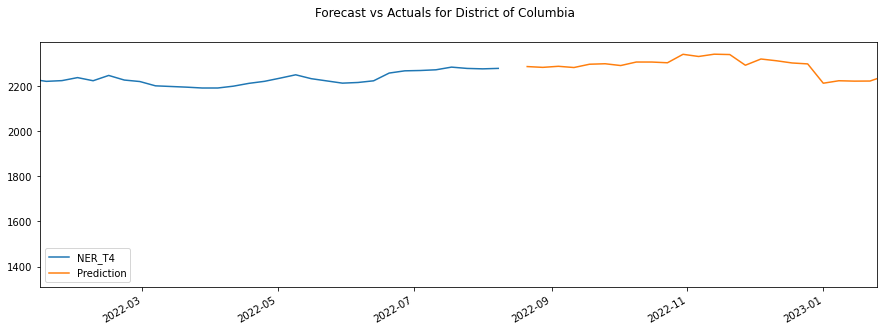

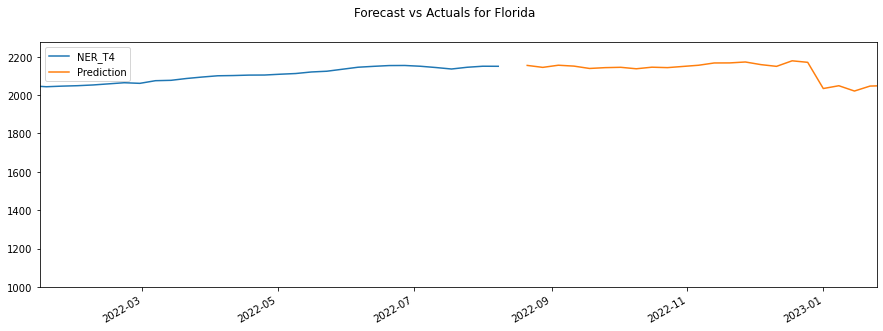

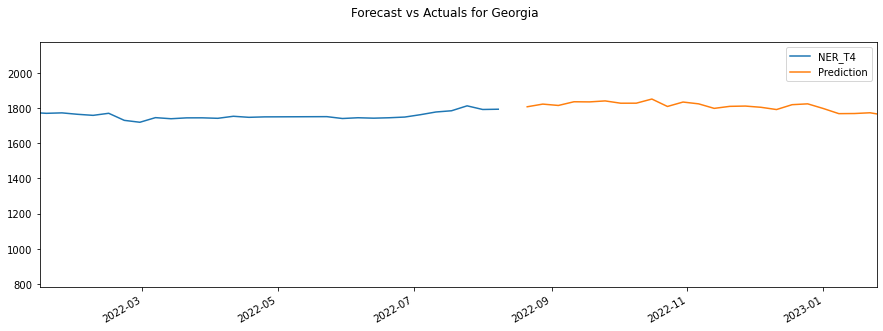

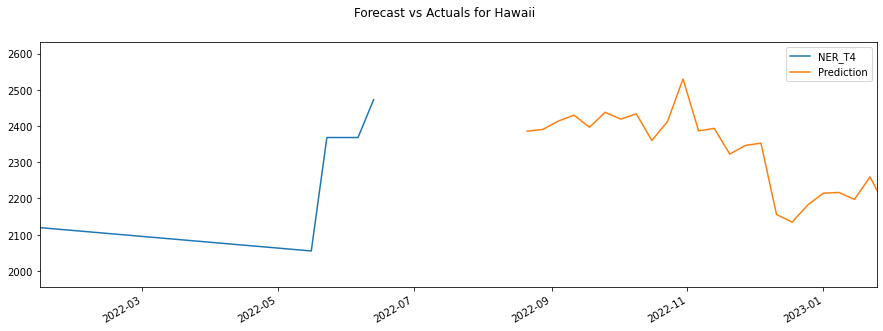

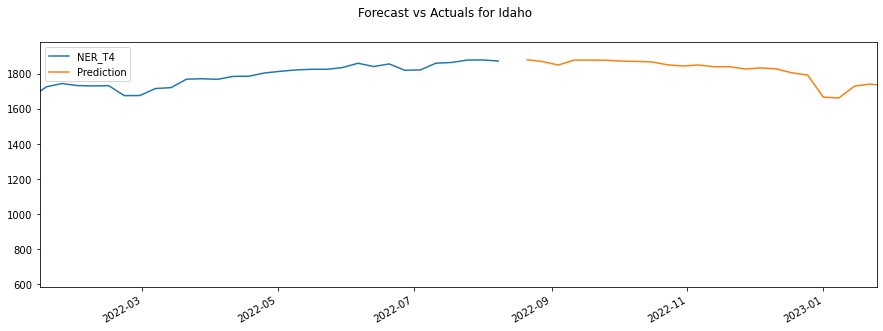

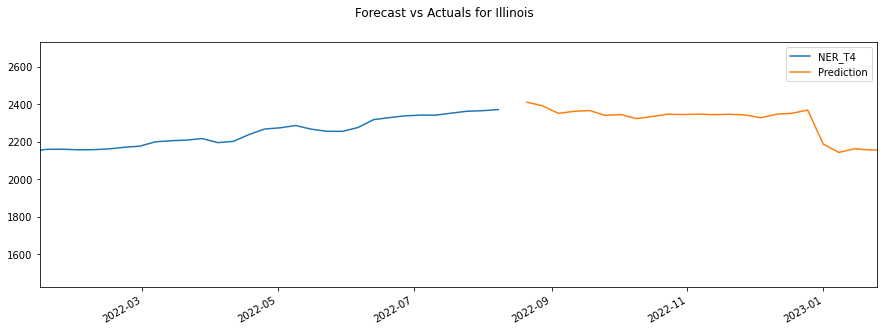

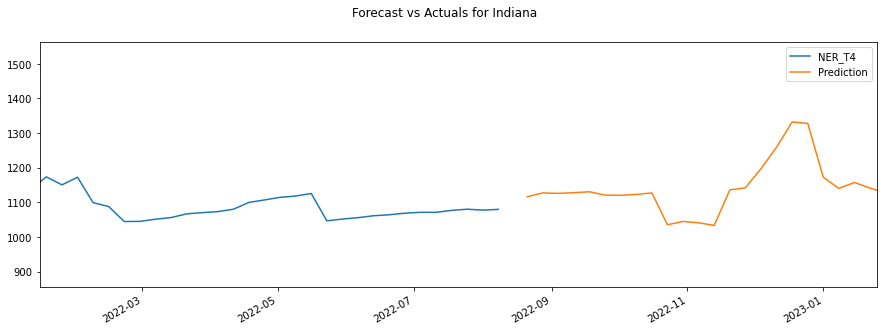

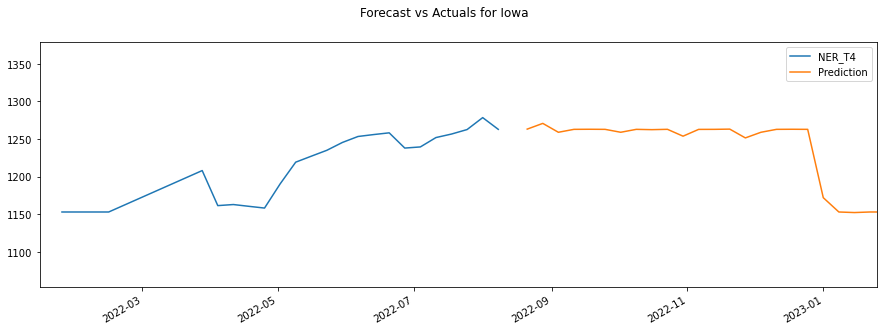

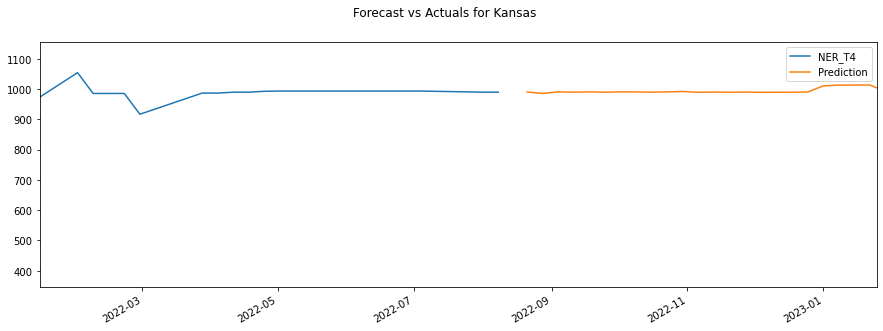

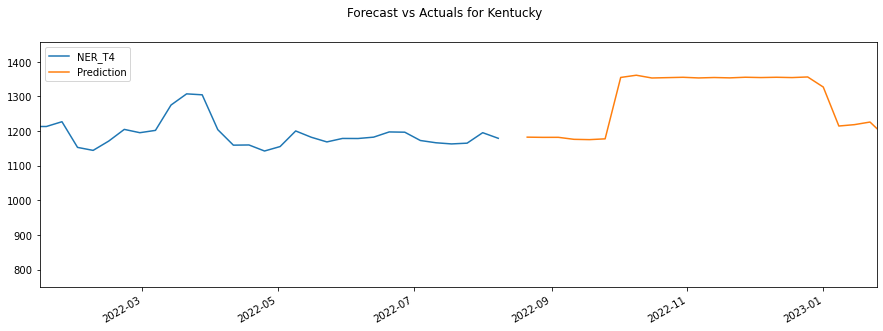

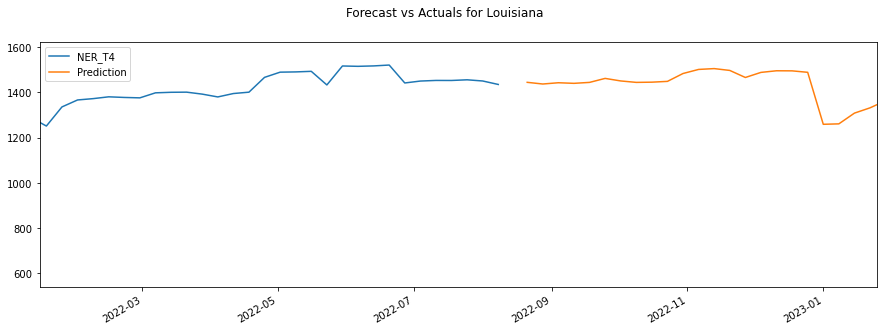

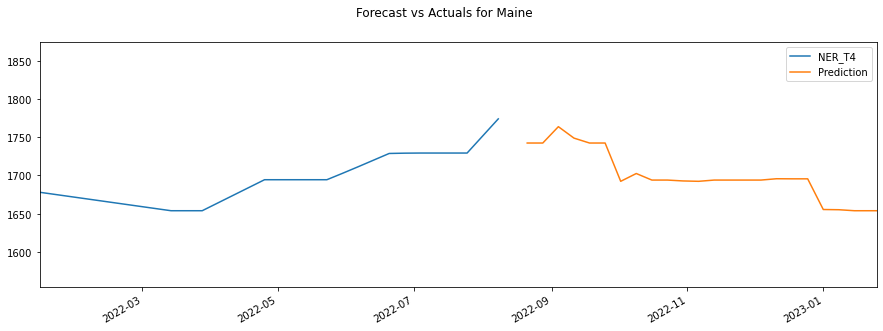

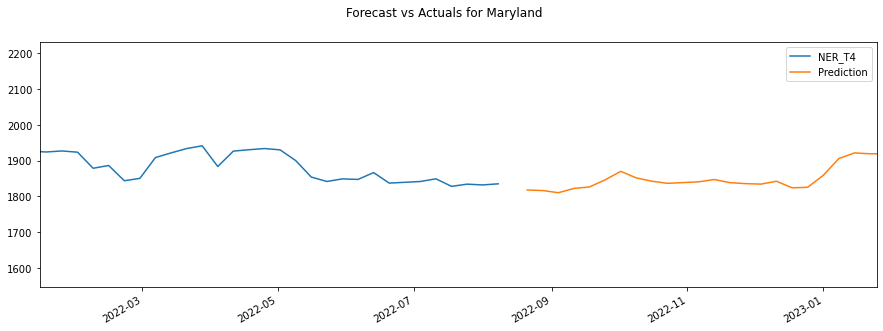

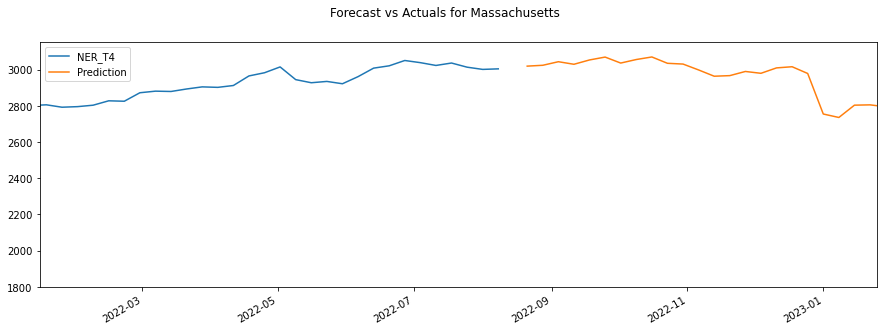

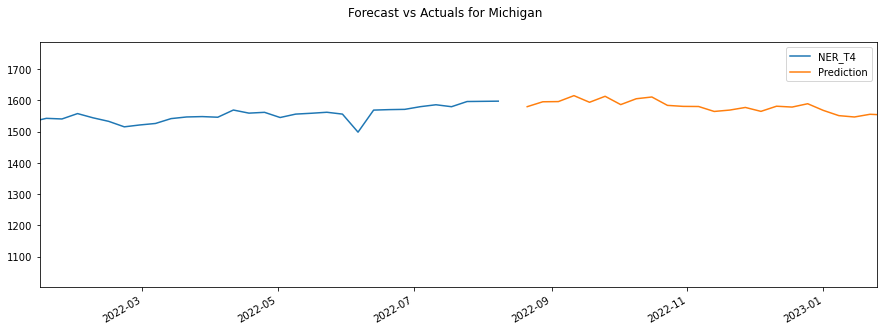

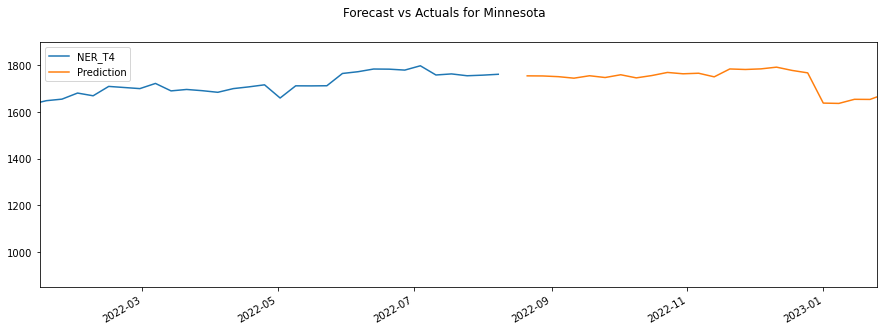

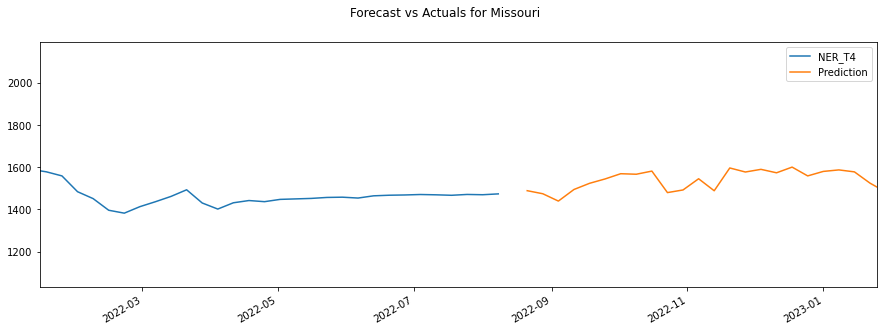

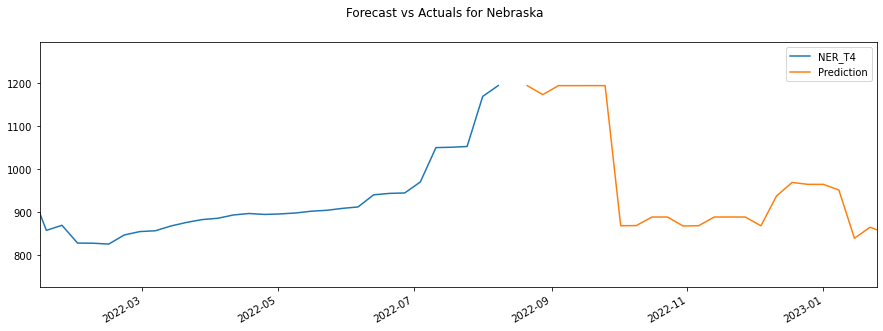

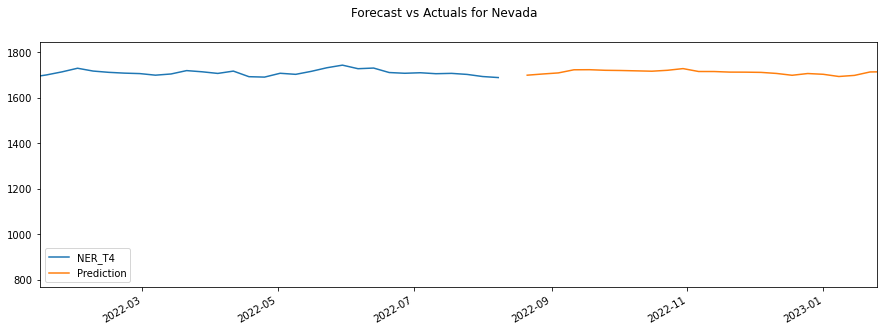

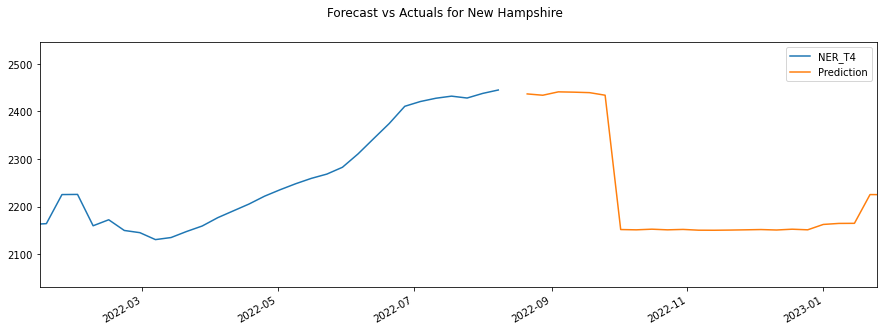

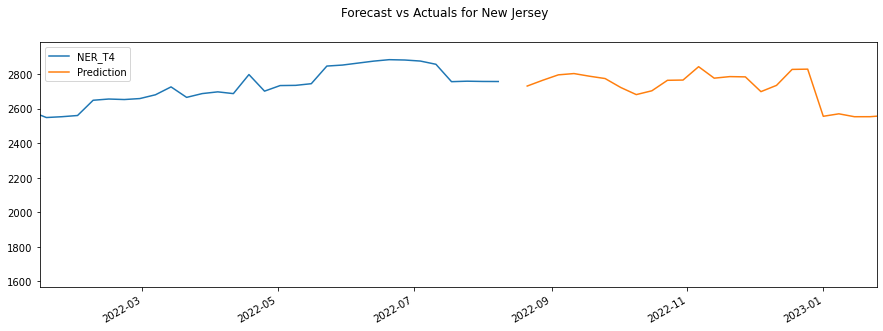

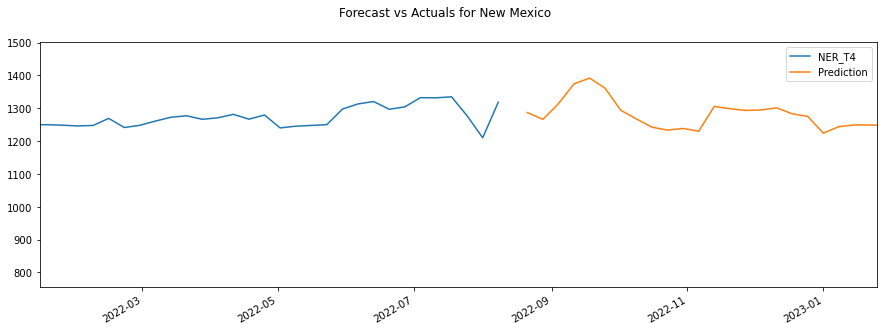

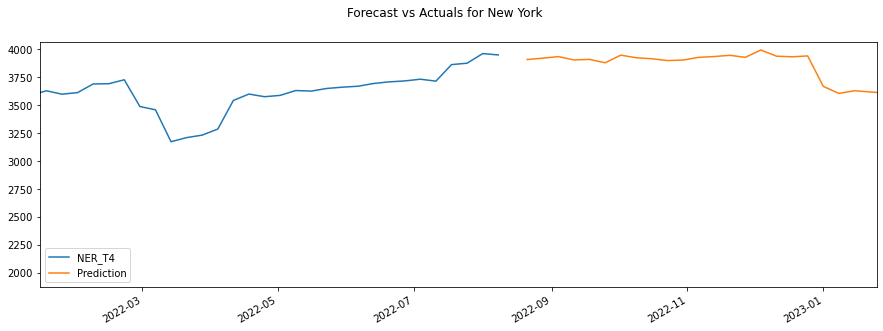

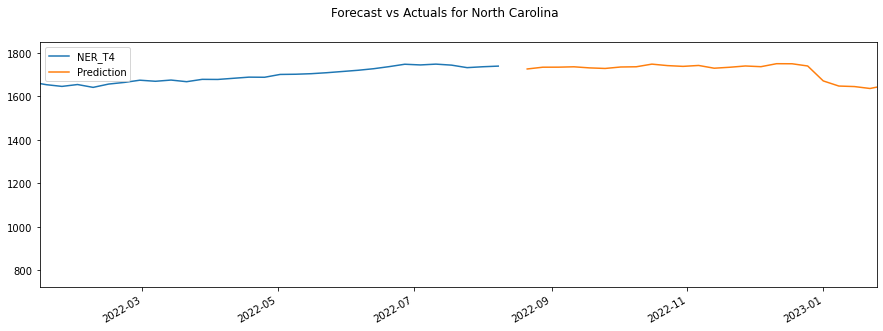

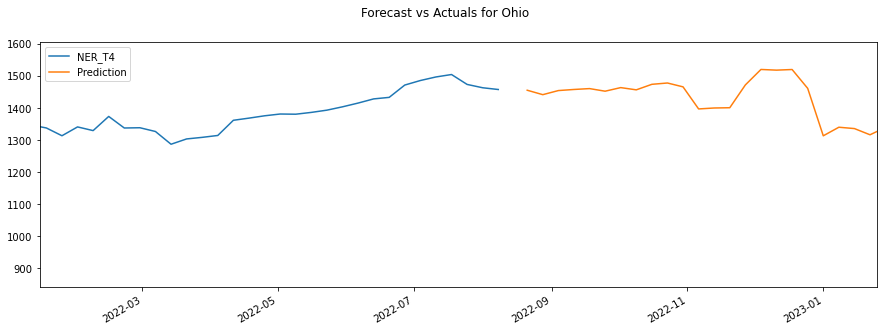

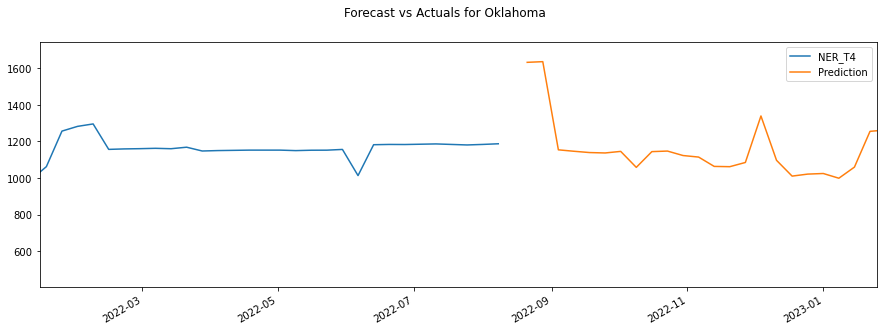

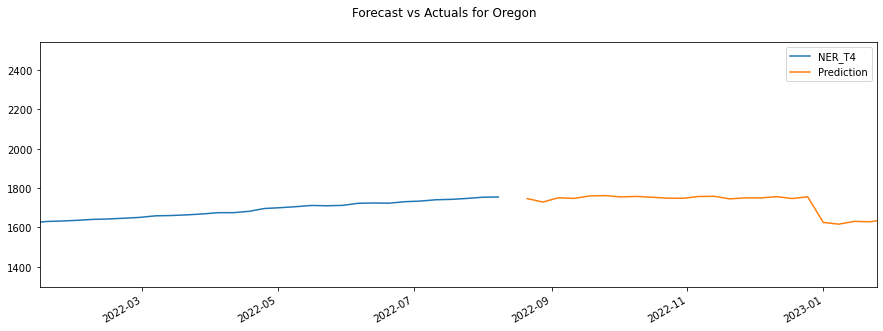

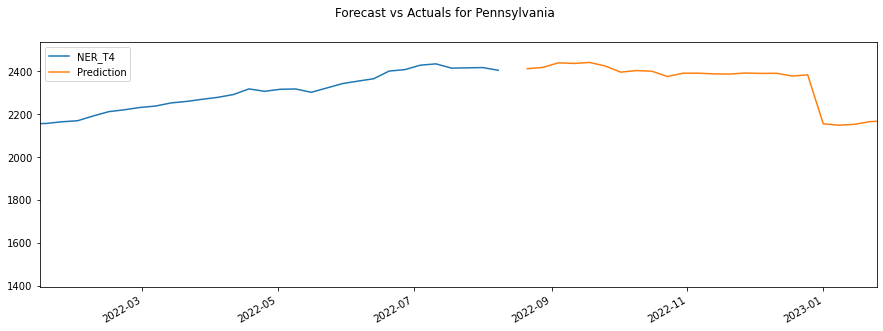

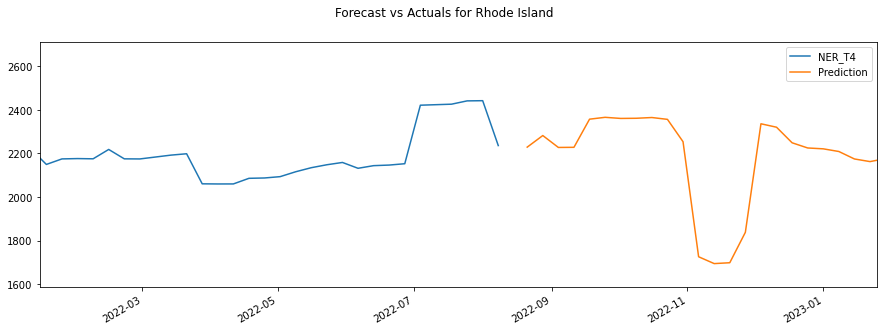

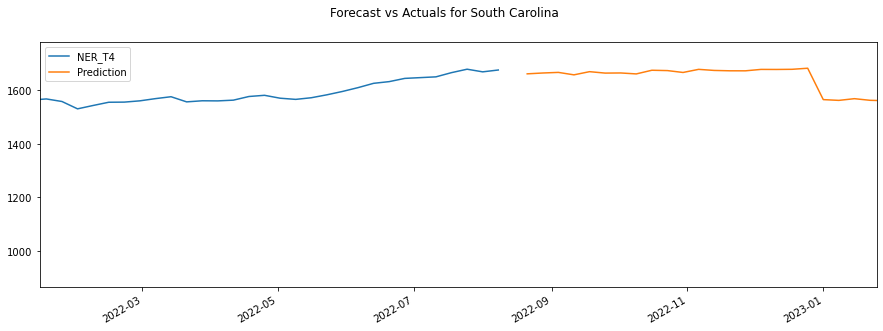

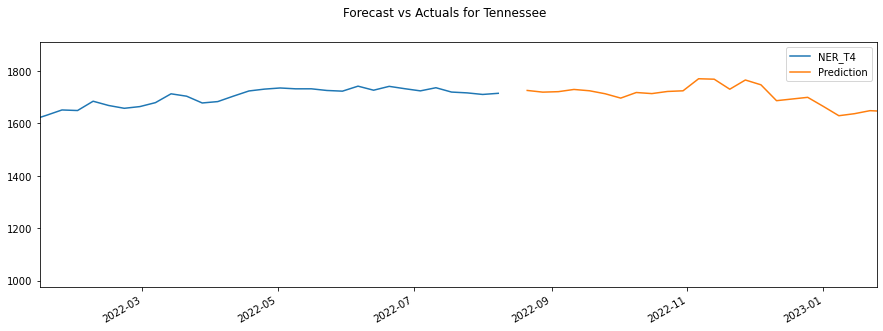

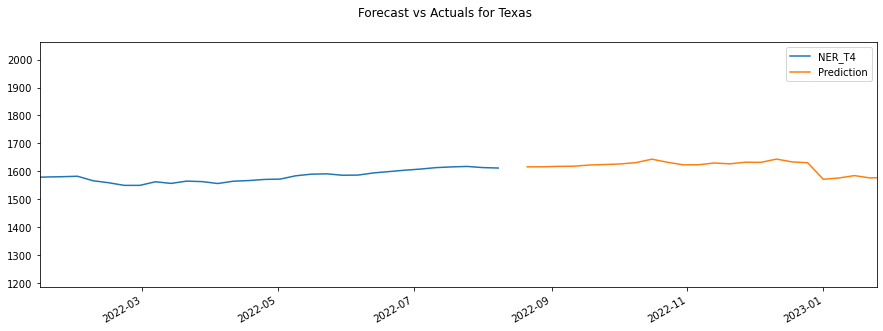

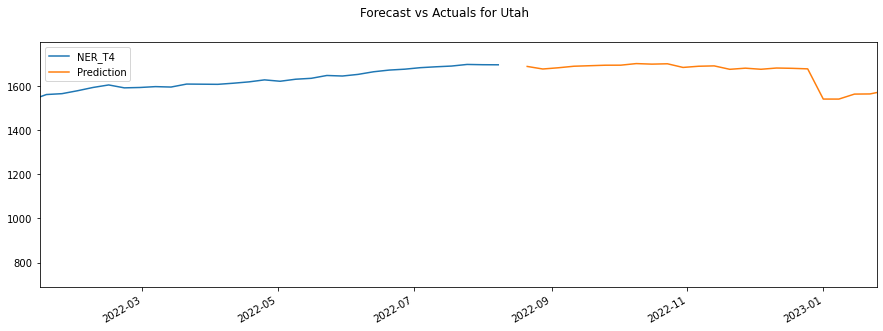

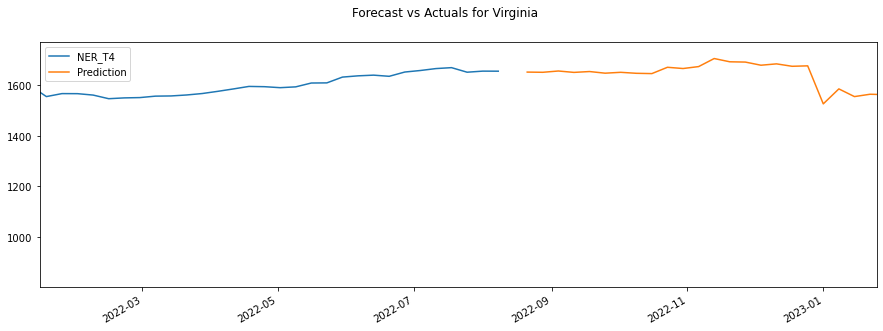

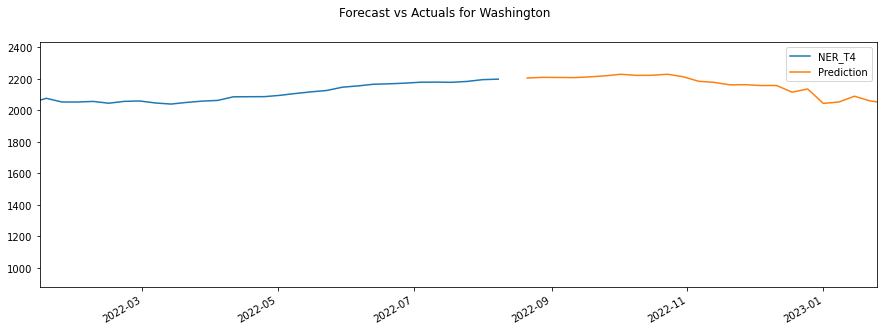

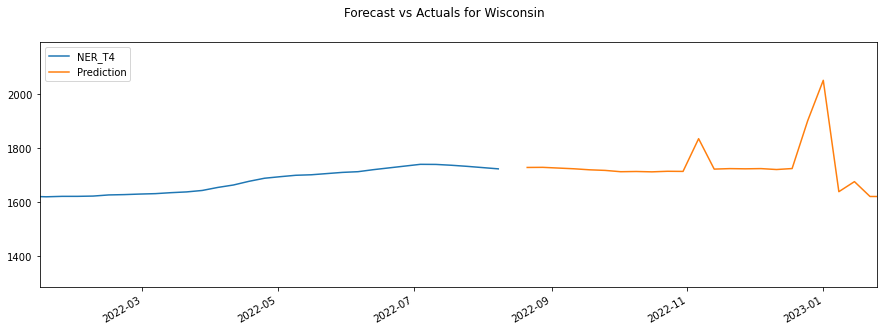

In [16]:
for unique_val, subset in subsets.items():
    subset['date'] = subset.index
    df_train = subset
    df_train = datetime_index(df_train, 'date')
    X_train, y_train = create_features(df_train, label='NER_T4')
    
    
    prediction_period = pd.DataFrame(pd.date_range('2022-08-15', periods=24, freq='W'))
    prediction_period = prediction_period.rename(columns = {0:'date'})
    df_test = datetime_index(prediction_period, 'date')

    
    X_test = create_features(df_test)
    
    
    reg = xgb.XGBRegressor(n_estimators=200)
    
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        early_stopping_rounds=50,
       verbose=False)     
    
    df_test['Prediction'] = reg.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    
    
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    _ = df_all[['NER_T4','Prediction']].plot(ax=ax, style=['-','-'])


    ax.set_xbound(lower='01-14-2022', upper='01-25-2023')
    ax.set_ylim(min(subset['NER_T4'])-100,max(subset['NER_T4'])+100)

    plot = plt.suptitle(f'Forecast vs Actuals for {unique_val}')

In [17]:
df_test.reset_index()['index']

0    2022-08-21
1    2022-08-28
2    2022-09-04
3    2022-09-11
4    2022-09-18
5    2022-09-25
6    2022-10-02
7    2022-10-09
8    2022-10-16
9    2022-10-23
10   2022-10-30
11   2022-11-06
12   2022-11-13
13   2022-11-20
14   2022-11-27
15   2022-12-04
16   2022-12-11
17   2022-12-18
18   2022-12-25
19   2023-01-01
20   2023-01-08
21   2023-01-15
22   2023-01-22
23   2023-01-29
Name: index, dtype: datetime64[ns]

In [18]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])
msa_data_lst

['Atlanta, GA',
 'Austin, TX',
 'Baltimore, MD',
 'Boston, MA',
 'Charleston, SC',
 'Charlotte, NC',
 'Chicago, IL',
 'Dallas, TX',
 'Denver, CO',
 'Houston, TX',
 'Jacksonville, FL',
 'Las Vegas, NV',
 'Los Angeles, CA',
 'Miami, FL',
 'Nashville, TN',
 'New York, NY',
 'Orlando, FL',
 'Phoenix, AZ',
 'Portland, OR',
 'Raleigh, NC',
 'Riverside, CA',
 'San Antonio, TX',
 'San Diego, CA',
 'San Francisco, CA',
 'San Jose, CA',
 'Seattle, WA',
 'Tampa, FL',
 'Washington, DC']

In [19]:
subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER_T4')

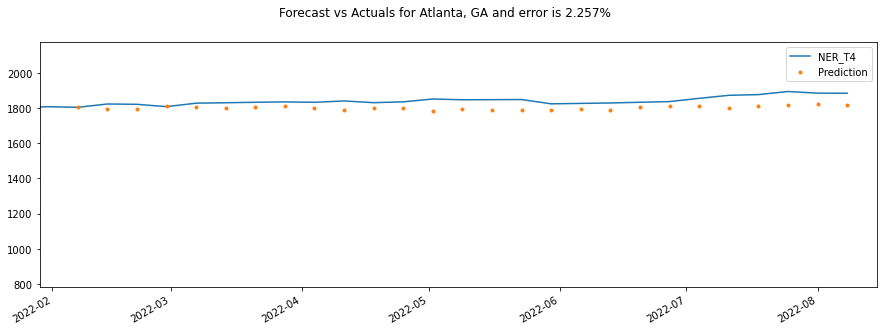

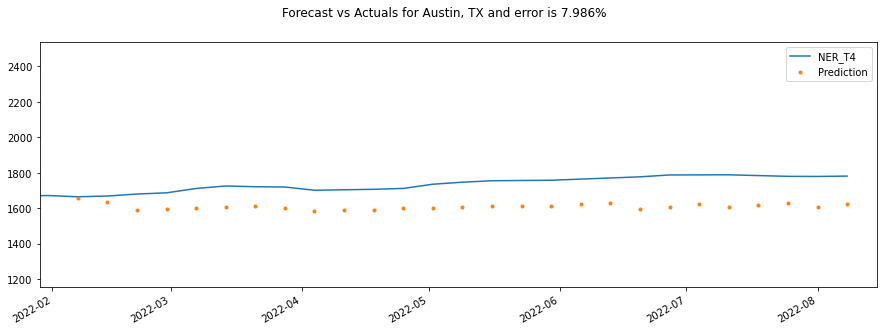

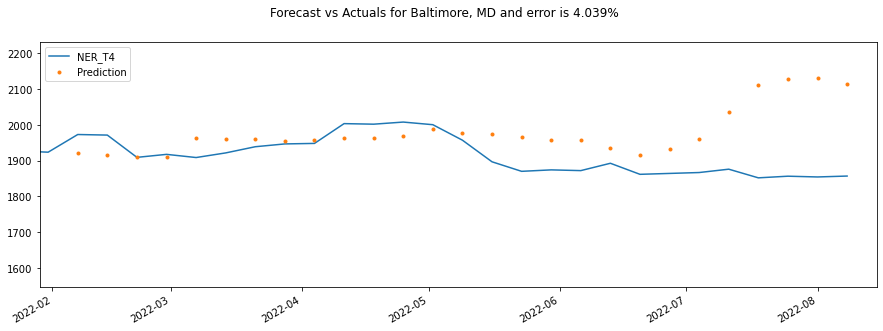

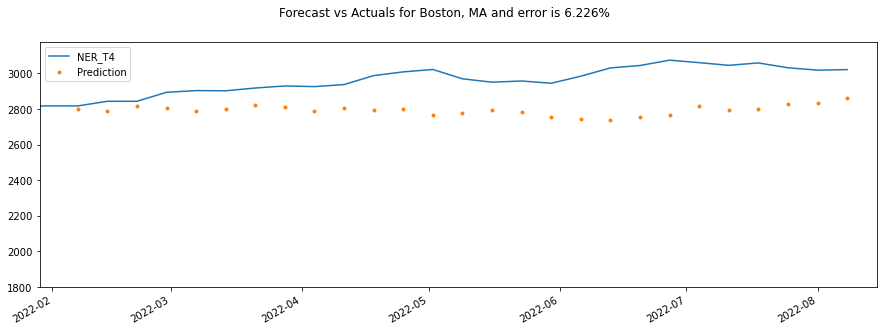

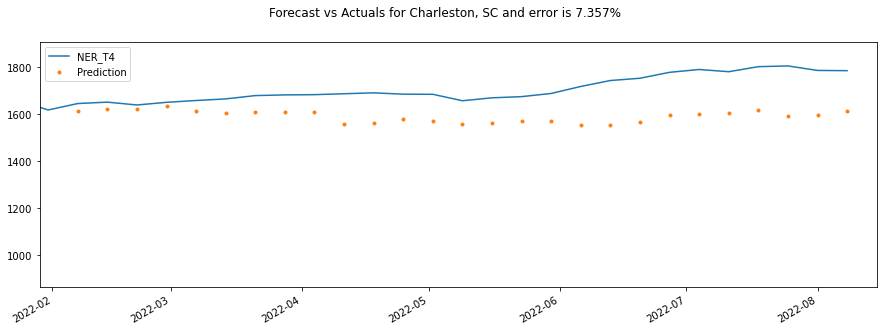

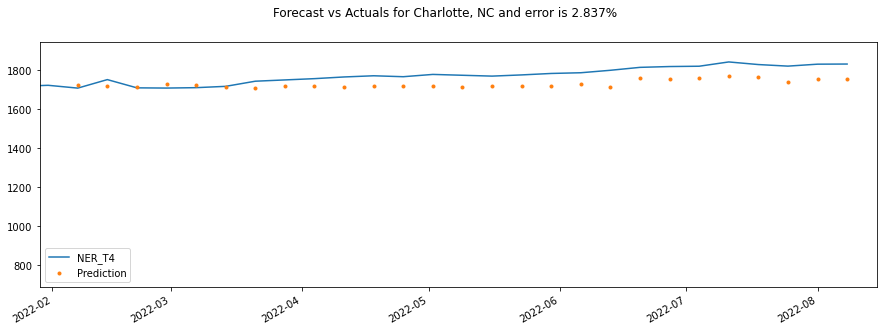

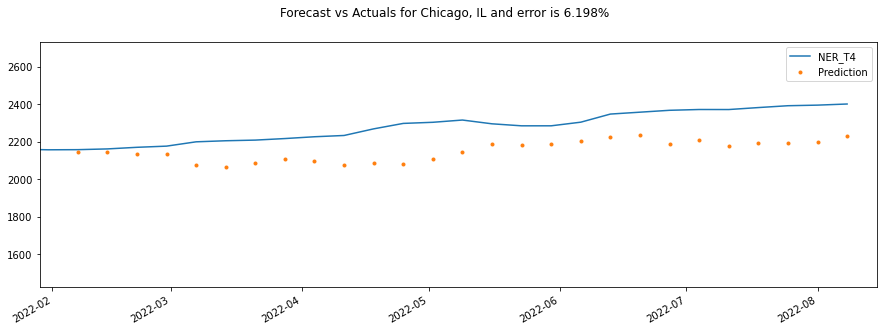

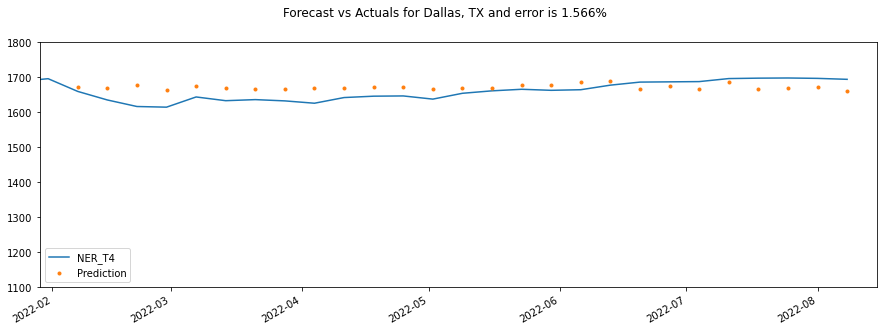

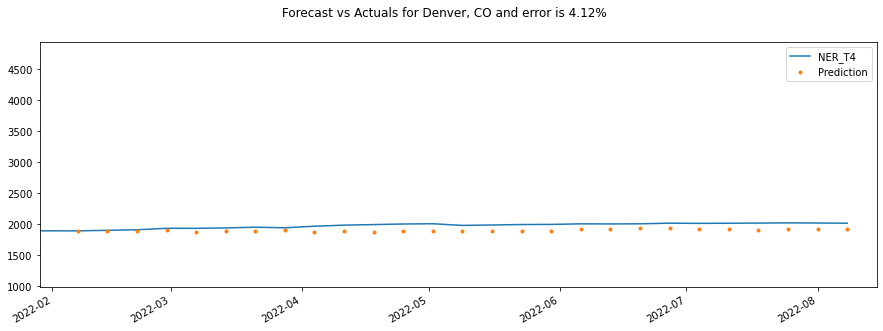

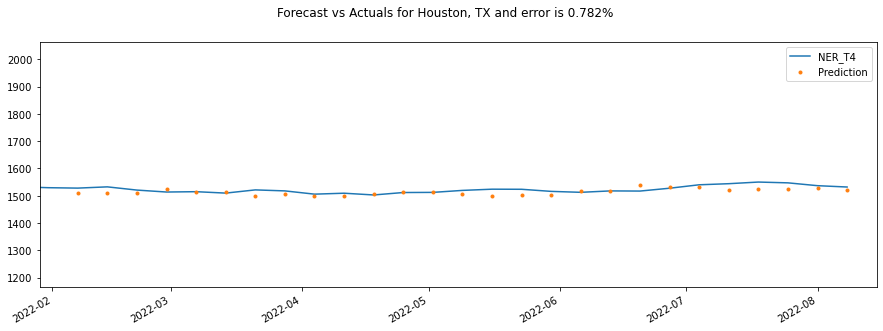

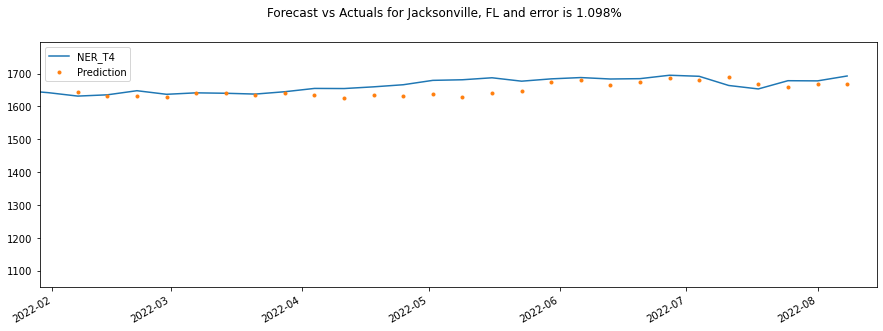

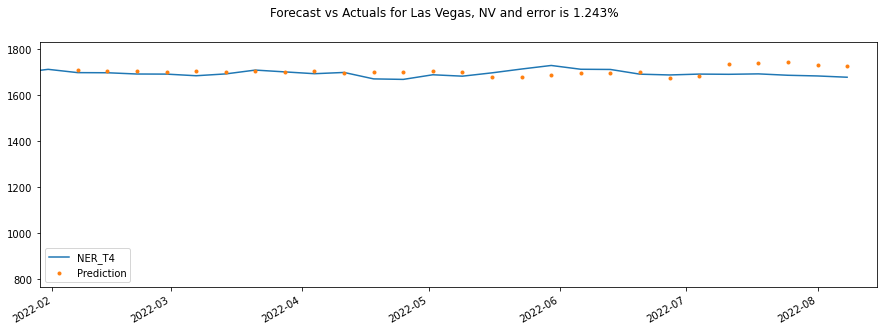

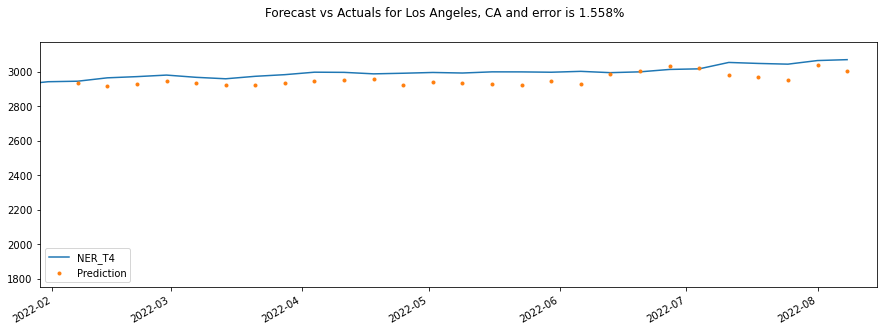

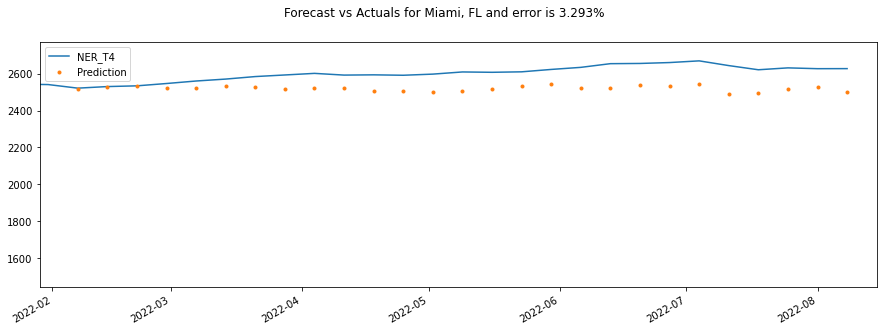

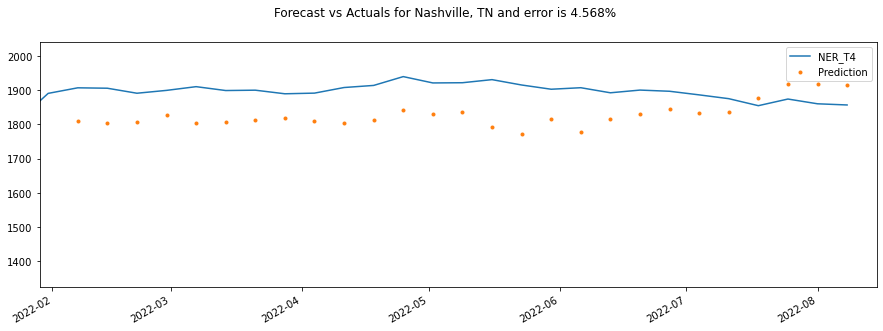

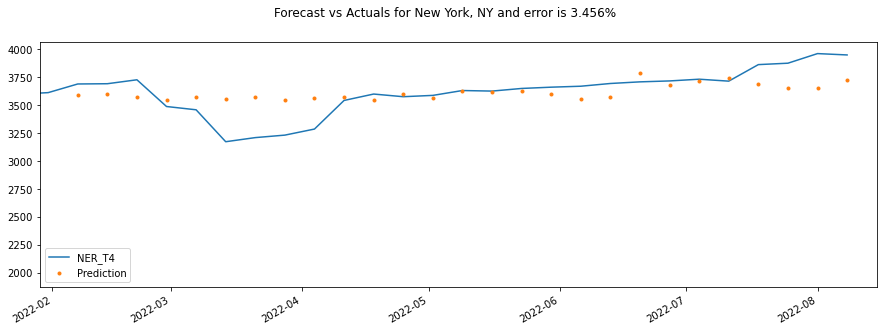

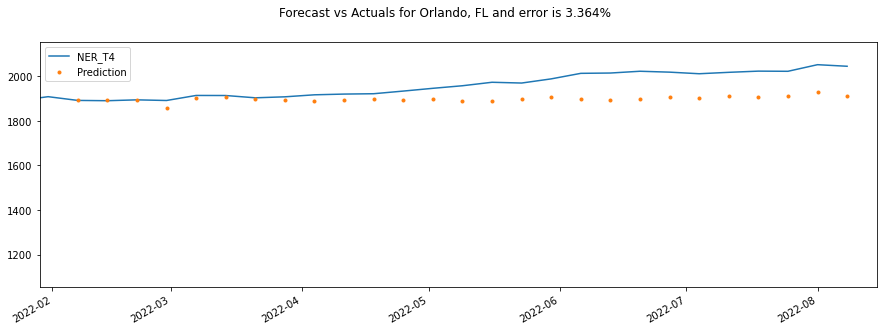

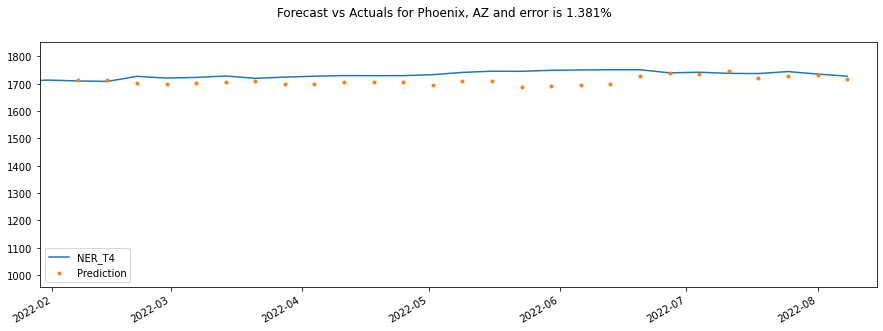

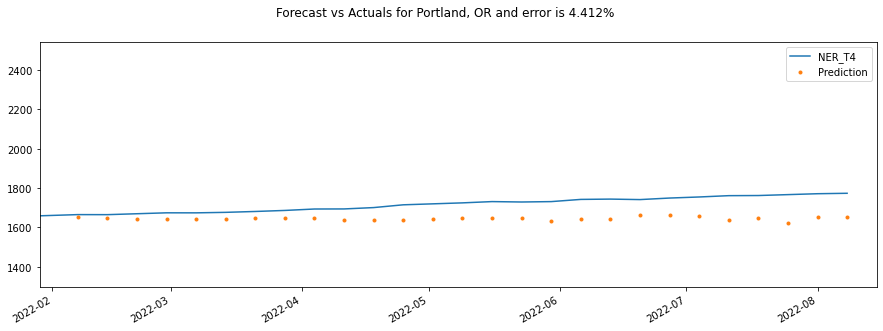

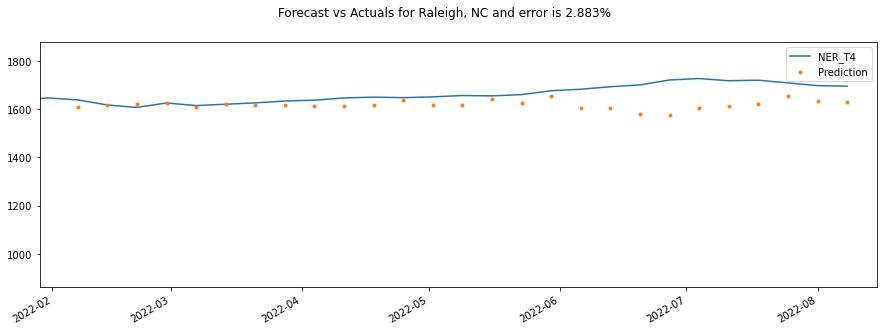

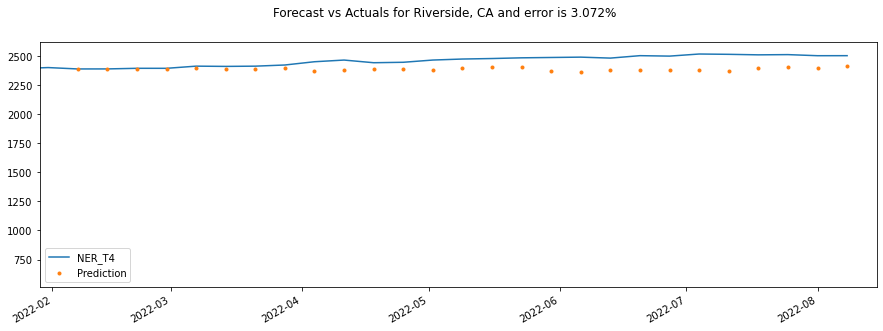

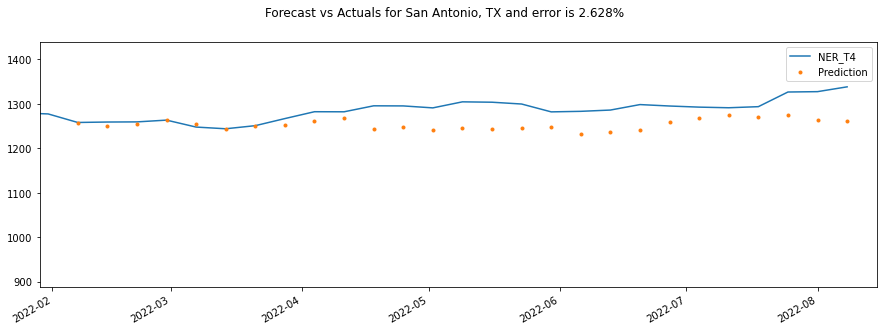

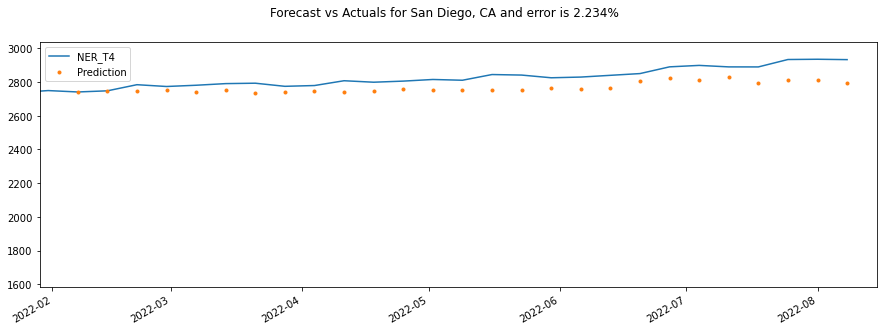

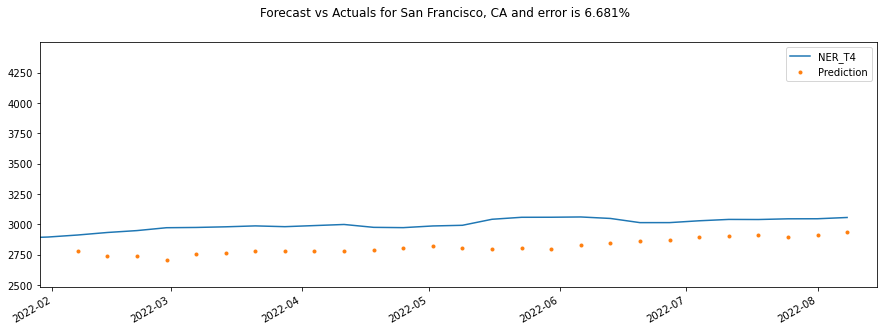

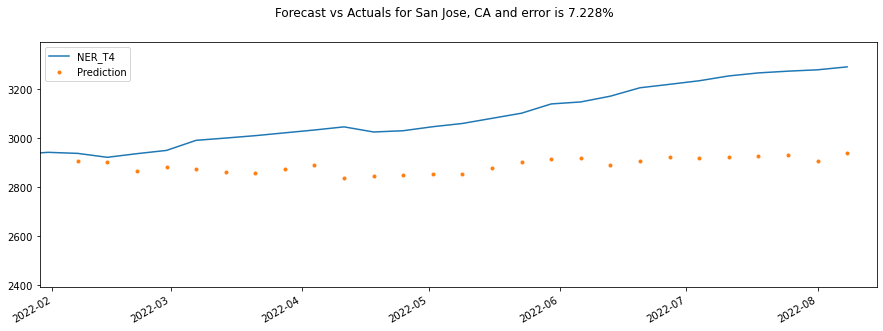

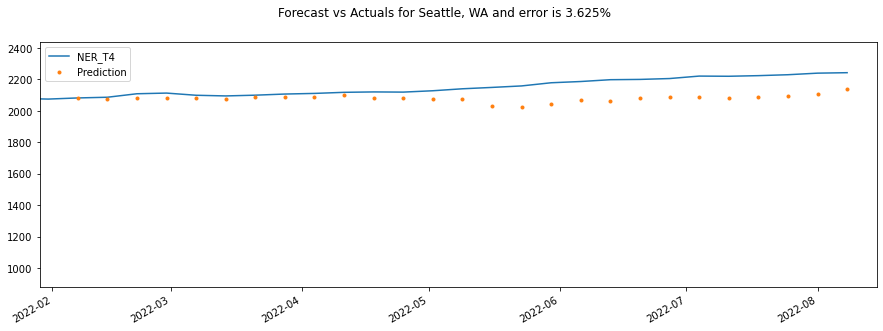

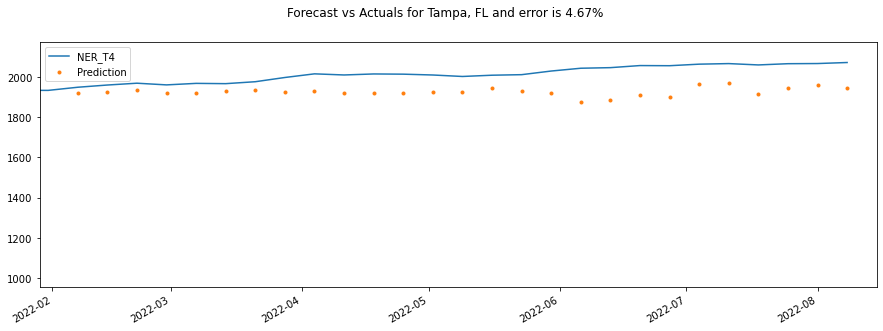

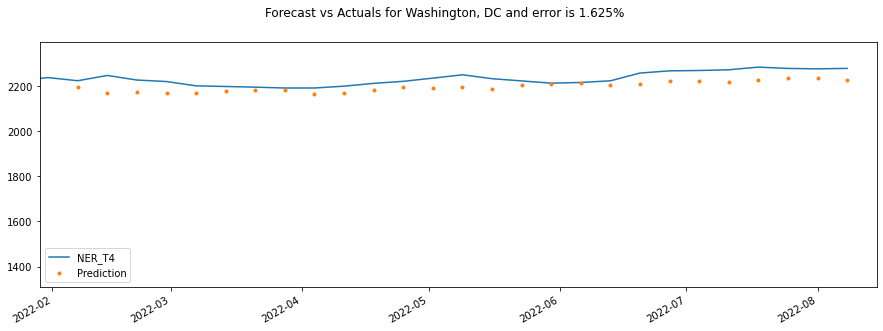

In [20]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst: 
        split_date = date(2022, 2, 1)
        subset['date'] = subset.index
        df_train = subset.loc[subset.index <= split_date].copy()
        df_test = subset.loc[subset.index > split_date].copy()
        df_train = datetime_index(df_train, 'date')
        df_test = datetime_index(df_test, 'date')
        X_train, y_train = create_features(df_train, label='NER_T4')

        X_test, y_test = create_features(df_test, label='NER_T4')
        reg = xgb.XGBRegressor(n_estimators=200)

        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

        df_test['Prediction'] = reg.predict(X_test)
        df_all = pd.concat([df_test, df_train], sort=False)

        mape = evaluation(df_test['NER_T4'], df_test['Prediction'])

        if mape < 0.10:
            f, ax = plt.subplots(1)
            f.set_figheight(5)
            f.set_figwidth(15)
            _ = df_all[['NER_T4','Prediction']].plot(ax=ax, style=['-','.'])


            ax.set_xbound(lower='01-29-2022', upper='08-15-2022')
            ax.set_ylim(min(subset['NER_T4'])-100,max(subset['NER_T4'])+100)

            plot = plt.suptitle(f'Forecast vs Actuals for {unique_val} and error is {round(mape*100,3)}%')

**Extracting the data into a df**

In [21]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
        print(unique_val)
        print(subset.tail(25))

Atlanta, GA
                 NER_T4        date
WEEK_START                         
2022-02-21  1820.903678  2022-02-21
2022-02-28  1807.615245  2022-02-28
2022-03-07  1827.391600  2022-03-07
2022-03-14  1829.922248  2022-03-14
2022-03-21  1832.492573  2022-03-21
2022-03-28  1834.762482  2022-03-28
2022-04-04  1832.163399  2022-04-04
2022-04-11  1840.064946  2022-04-11
2022-04-18  1830.241308  2022-04-18
2022-04-25  1834.992967  2022-04-25
2022-05-02  1851.081752  2022-05-02
2022-05-09  1846.679912  2022-05-09
2022-05-16  1847.391480  2022-05-16
2022-05-23  1847.988621  2022-05-23
2022-05-30  1823.638586  2022-05-30
2022-06-06  1826.387210  2022-06-06
2022-06-13  1828.562562  2022-06-13
2022-06-20  1832.731754  2022-06-20
2022-06-27  1836.425153  2022-06-27
2022-07-04  1854.831201  2022-07-04
2022-07-11  1871.996127  2022-07-11
2022-07-18  1875.978693  2022-07-18
2022-07-25  1893.591580  2022-07-25
2022-08-01  1884.224350  2022-08-01
2022-08-08  1883.757448  2022-08-08
Austin, TX
     

In [22]:
column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

df_xgboost = pd.DataFrame(columns = column_names)
df_xgboost

,Model,Time,MSA,Actuals,Predictions,MAPE score


In [23]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
    
        column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

        df = pd.DataFrame(columns = column_names)

                
        algorithm_name = 'XGBoost Model'
        
        ## experimenting with a dataset
        prediction_period = 25
        
        
        df_train = subset[:-prediction_period]
        df_test = subset[-prediction_period:]
        df_train = datetime_index(df_train, 'date')
        df_test = datetime_index(df_test, 'date')
        
        X_train, y_train = create_features(df_train, label='NER_T4')
        X_test, y_test = create_features(df_test, label='NER_T4')
        
        
        reg = xgb.XGBRegressor(n_estimators=500)

        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

        df_test['Prediction'] = reg.predict(X_test)
        df_all = pd.concat([df_test, df_train], sort=False)

        mape_score = evaluation(df_test['NER_T4'], df_test['Prediction'])

                
        #print(df_test.reset_index()['index'])
        
        df['Actuals'] =  df_test['NER_T4']
        df['Predictions'] =  df_test['Prediction']
        df['MAPE score'] =  mape_score
        df['Time'] =  list(df_test.reset_index()['index'])
        df['Model'] =  algorithm_name
        df['MSA'] =  unique_val

        df_xgboost = df_xgboost.append(df, ignore_index=True)

In [24]:
df_xgboost

,Model,Time,MSA,Actuals,Predictions,MAPE score
0,XGBoost Model,2022-02-21,"Atlanta, GA",1820.903678,1791.592285,0.018612
1,XGBoost Model,2022-02-28,"Atlanta, GA",1807.615245,1798.767090,0.018612
2,XGBoost Model,2022-03-07,"Atlanta, GA",1827.391600,1806.341431,0.018612
3,XGBoost Model,2022-03-14,"Atlanta, GA",1829.922248,1817.876587,0.018612
4,XGBoost Model,2022-03-21,"Atlanta, GA",1832.492573,1802.317139,0.018612
...,...,...,...,...,...,...
695,XGBoost Model,2022-07-11,"Washington, DC",2271.175968,2240.195801,0.011160
696,XGBoost Model,2022-07-18,"Washington, DC",2283.010037,2240.256592,0.011160
697,XGBoost Model,2022-07-25,"Washington, DC",2277.249740,2248.447754,0.011160
698,XGBoost Model,2022-08-01,"Washington, DC",2275.348560,2238.063721,0.011160


In [25]:
df_xgboost.to_csv("df_xgboost_msa_level_TRAILING.csv")

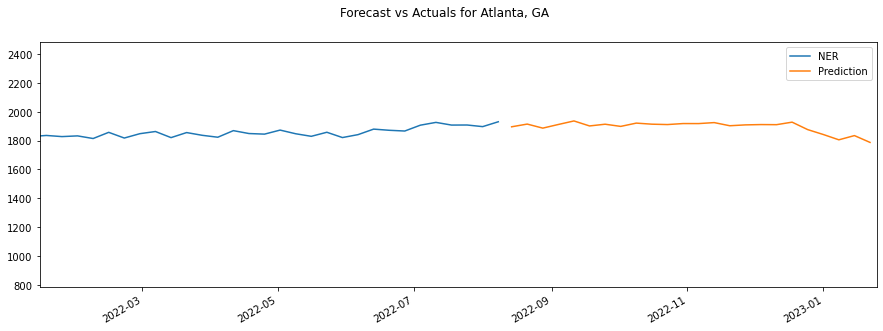

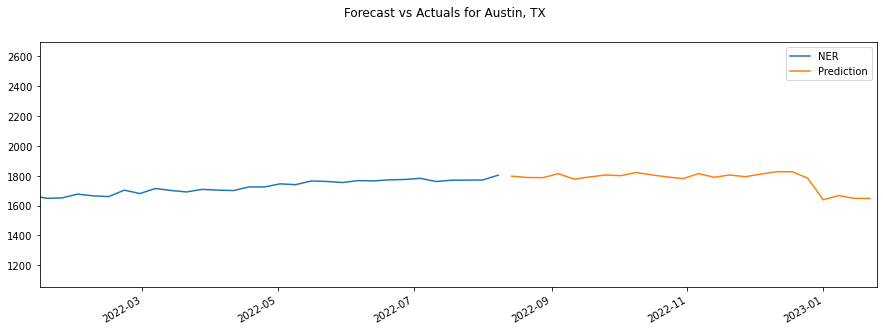

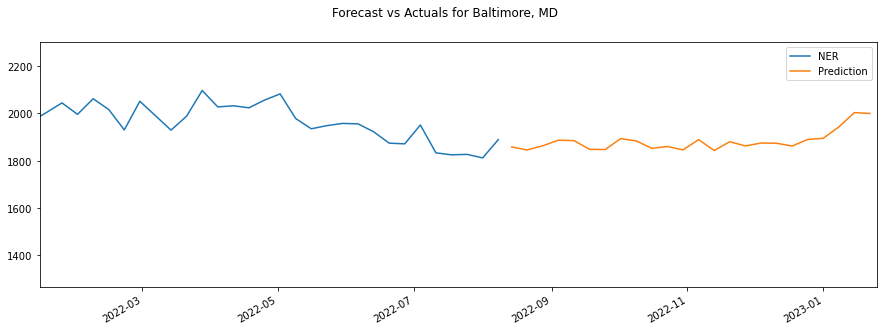

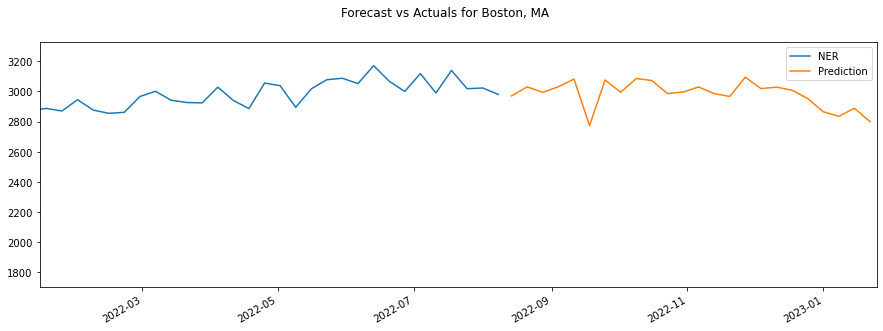

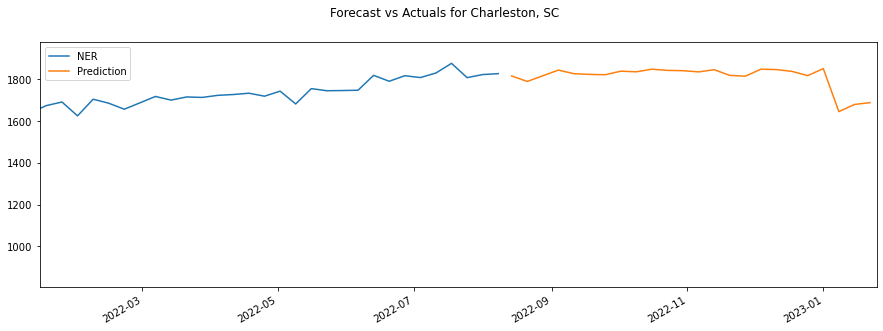

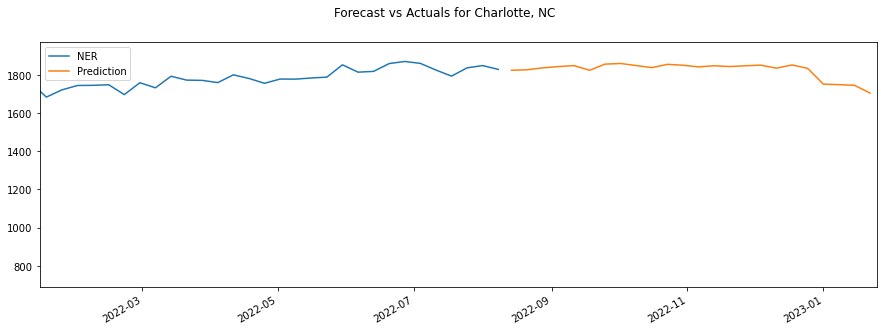

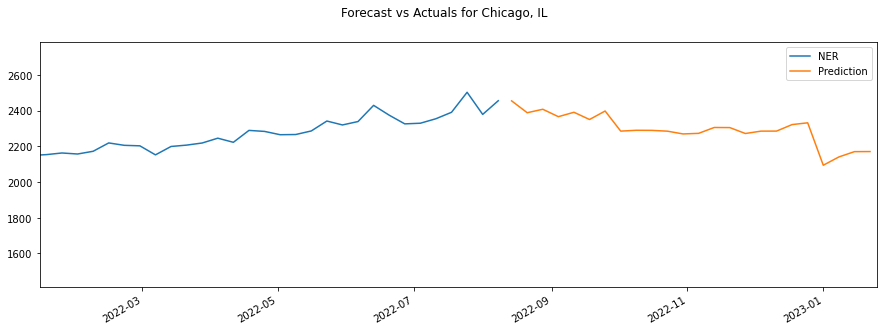

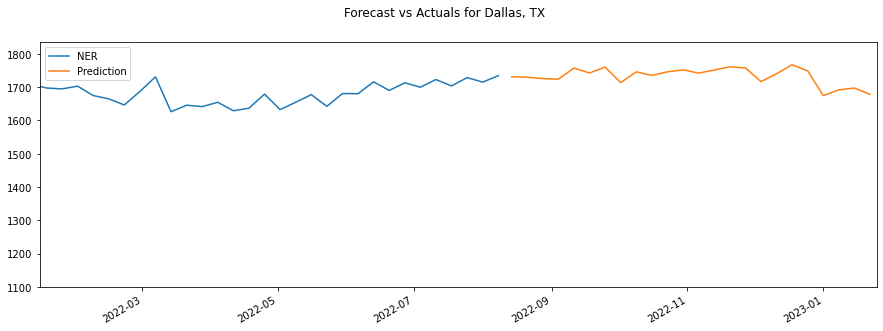

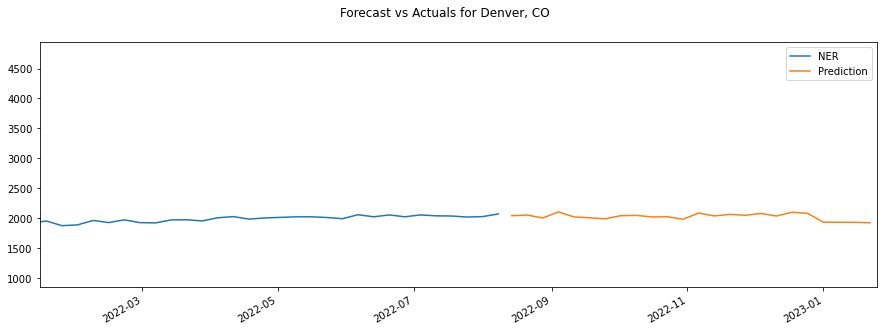

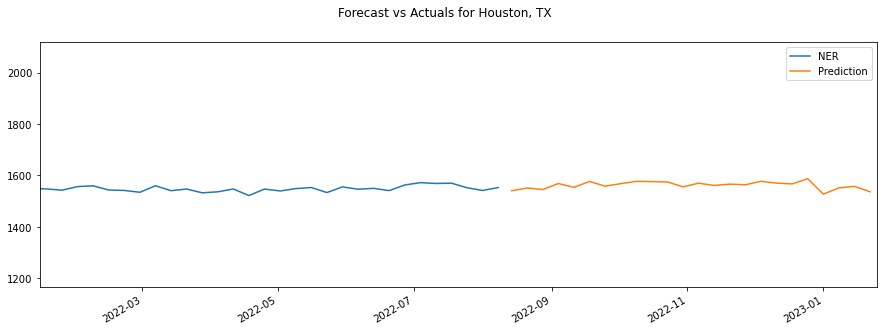

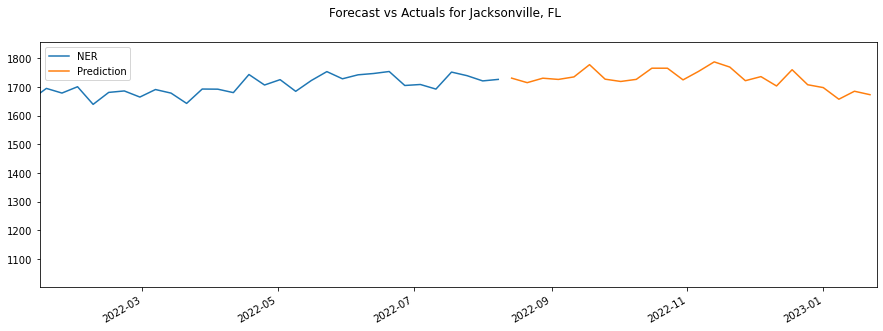

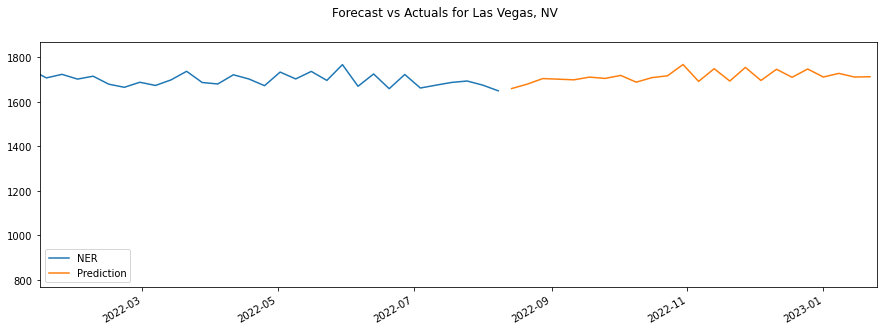

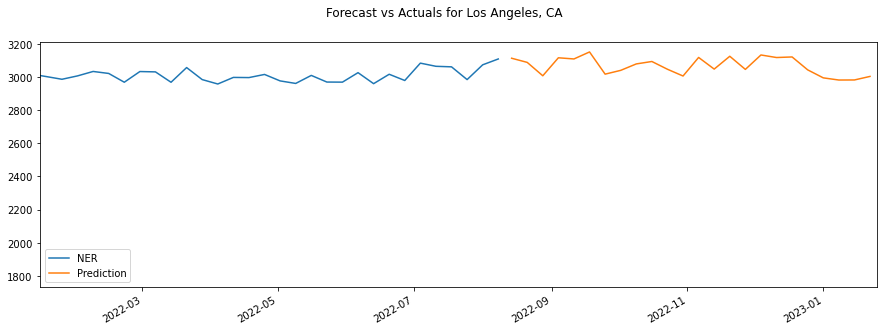

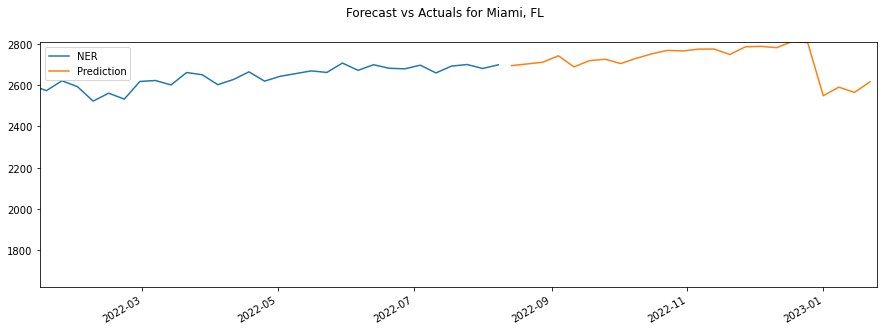

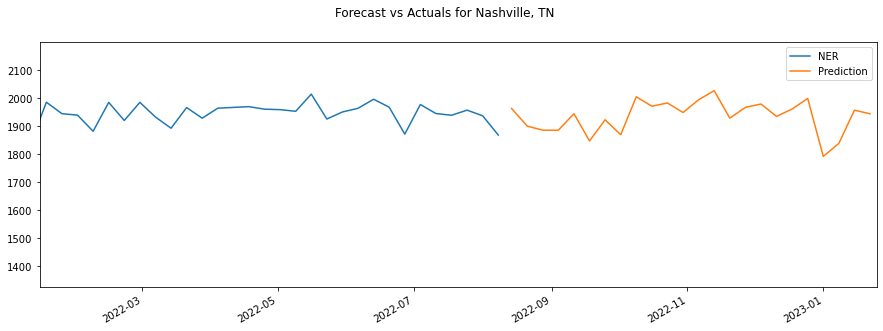

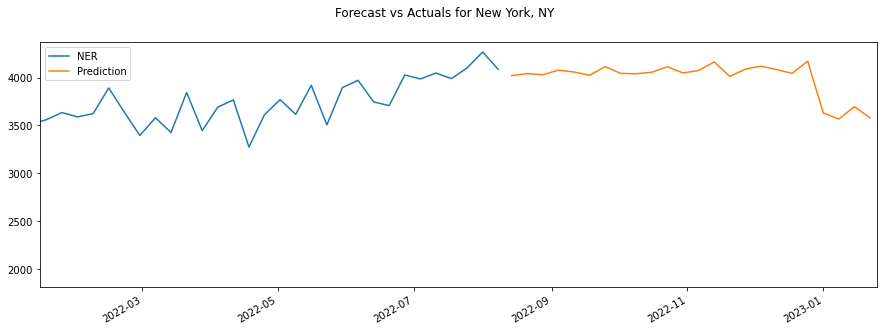

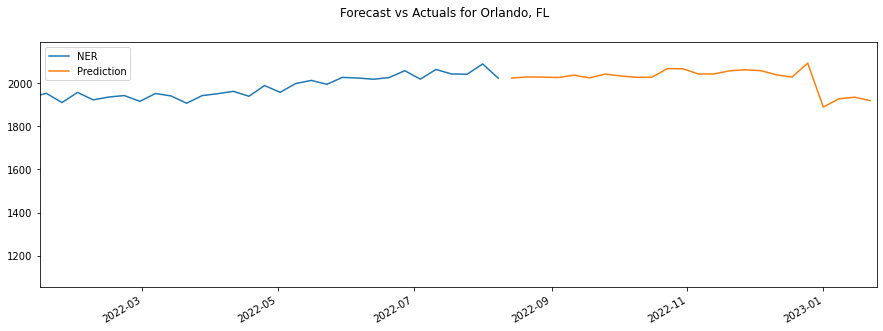

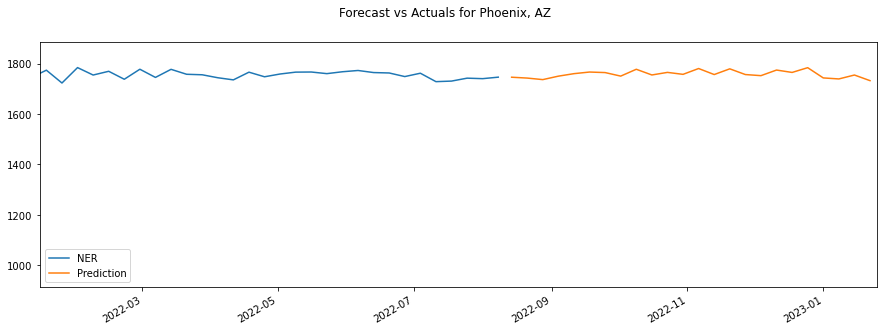

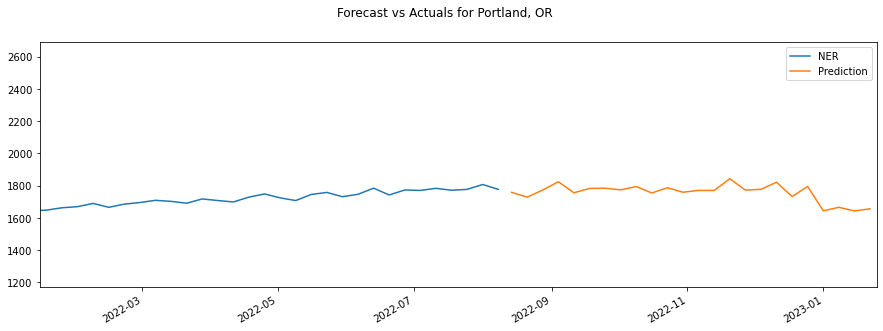

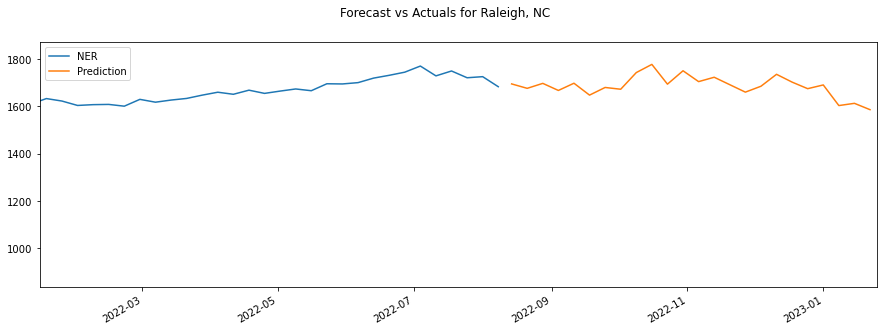

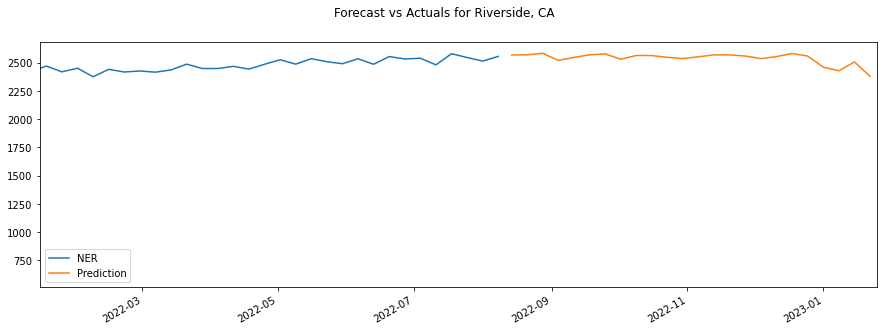

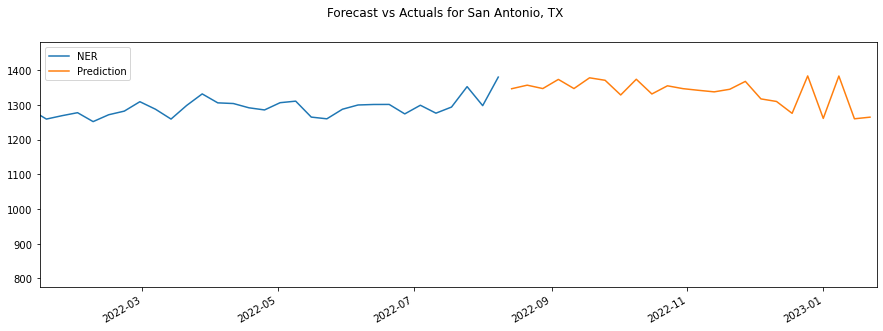

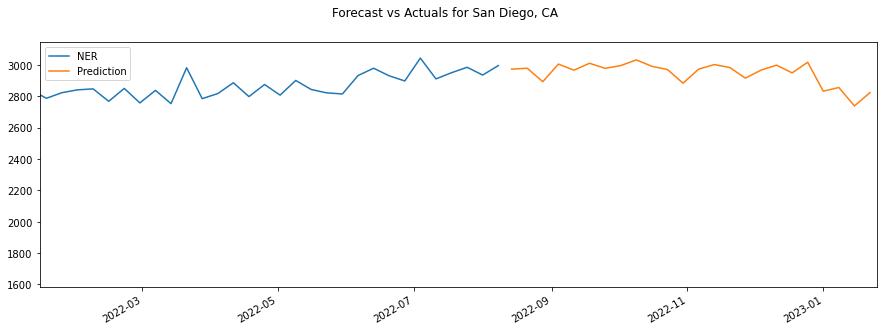

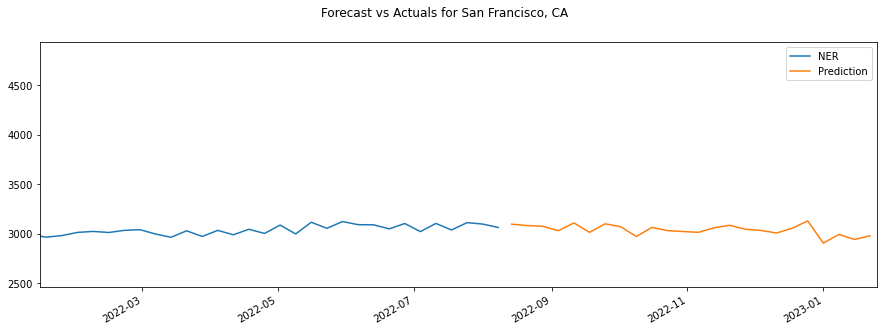

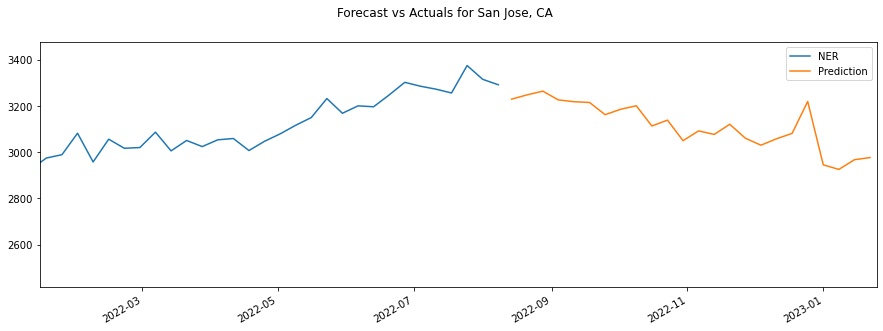

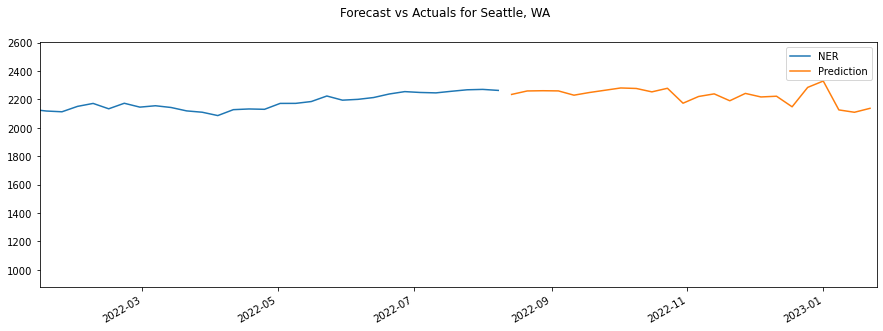

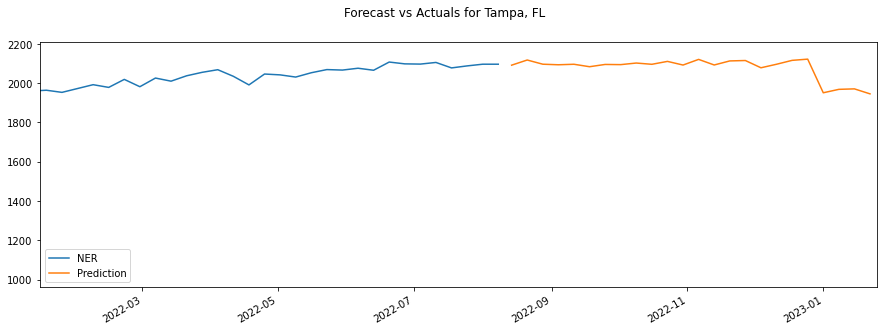

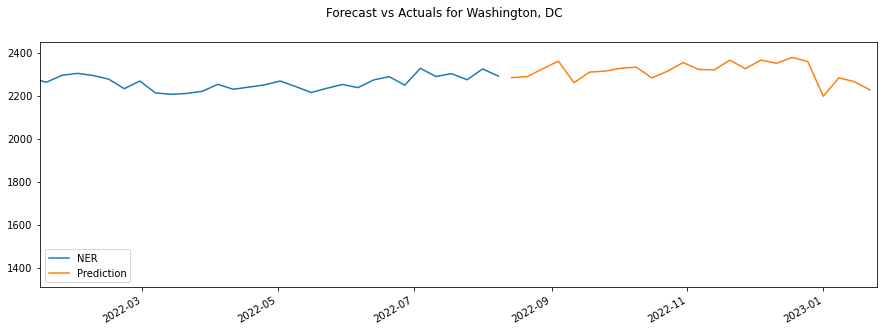

In [58]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst: 
        subset['date'] = subset.index
        df_train = subset
        df_train = datetime_index(df_train, 'date')
        X_train, y_train = create_features(df_train, label='NER')


        prediction_period = pd.DataFrame(pd.date_range('2022-08-08', periods=24, freq='W'))
        prediction_period = prediction_period.rename(columns = {0:'date'})
        df_test = datetime_index(prediction_period, 'date')


        X_test = create_features(df_test)


        reg = xgb.XGBRegressor(n_estimators=200)

        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

        df_test['Prediction'] = reg.predict(X_test)
        df_all = pd.concat([df_test, df_train], sort=False)


        f, ax = plt.subplots(1)
        f.set_figheight(5)
        f.set_figwidth(15)
        _ = df_all[['NER','Prediction']].plot(ax=ax, style=['-','-'])


        ax.set_xbound(lower='01-14-2022', upper='01-25-2023')
        ax.set_ylim(min(subset['NER'])-100,max(subset['NER'])+100)

        plot = plt.suptitle(f'Forecast vs Actuals for {unique_val}')